# Data loading

In [50]:
import time
import pandas as pd
import pickle
from datetime import date
import numpy as np
import yaml
import matplotlib.pyplot as plt

#sklearn functions
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline #, make_union
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import set_config
set_config(display="diagram")

#SVR & GMM
from sklearn.svm import SVR
from sklearn.linear_model import ARDRegression

sv_wide_df = pd.read_pickle(open("../data/processed/20220301_straatvinken_abt_complete_df.pkl", "rb"))
# load training dataset
X_train, X_test, y_train, y_test = pickle.load(open(f"../data/training/20220210_train_test_data.pkl", 'rb'))

# get column definitions
COLUMN_CONFIG_FILE = "../src/aicityflowsstraatvinken/config_2022_1.3.yaml"
config = yaml.load(stream=open(COLUMN_CONFIG_FILE, 'r'), Loader=yaml.FullLoader)
Y_s = config["Y_s"]
one_hot_cols = config["one_hot_cols"]
num_pred_remain_cols = config["num_pred_remain_cols"]
num_pred_segm_cols = config["num_pred_segm_cols"]
num_pred_minmax_cols = config["num_pred_minmax_cols"]

one_hot_categories = list(sv_wide_df[one_hot_cols].apply(lambda x: list(set(x)), axis=0).values)
prefix = np.hstack([[one_hot_cols[ix]] * (len(cat_list)) for ix, cat_list in enumerate(one_hot_categories)]) 
suffix =  np.hstack([cat_list for cat_list in one_hot_categories]).astype(str)
one_hot_col_names = [f"{prefix}_{suffix}" for prefix, suffix in zip(prefix, suffix)]

num_pred_minmax = num_pred_minmax_cols.copy()
num_pred_minmax.extend(num_pred_segm_cols)

cols = one_hot_col_names.copy()
cols.extend(num_pred_minmax)
cols.extend(num_pred_remain_cols)

class Columns(BaseEstimator, TransformerMixin):
    def __init__(self, names=None):
        self.names = names

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X):
        return X[self.names]
    
num_pred_minmax = num_pred_minmax_cols.copy()
num_pred_minmax.extend(num_pred_segm_cols)

In [80]:
for col in one_hot_cols:
    print(pd.unique(sv_wide_df[col]))

['1' '2' nan]
[103. 102. 114. 110. 104. 116. 107.  nan 111. 113.]
['L3' 'S3' 'L1' 'L2' 'S2' '-9' 'S1' 'PII' nan]


In [89]:
sv_wide_df.iloc[sv_wide_df.index[np.any(sv_wide_df[one_hot_cols].isna(), axis=1)]][one_hot_cols]



,verh,morf,wegcat
681,NaN,103.0,L2
730,NaN,103.0,L3
1618,NaN,NaN,NaN
1663,NaN,103.0,L3
1707,NaN,103.0,L3
1803,NaN,103.0,L3
1835,NaN,103.0,L3
1880,NaN,103.0,L3
2003,NaN,103.0,L3
2035,NaN,103.0,L3


In [93]:
df = pickle.load(open("../data/processed/20220302_straatvinken_abt_complete_df.pkl", "rb"))
df[["kern_prop"]]

,kern_prop
0,0.958814
1,1.000000
2,1.000000
3,1.000000
4,0.998289
...,...
3545,0.787783
3546,0.931315
3547,0.457620
3548,0.180045


In [74]:
print(one_hot_cols)
one_hot_categories = list(sv_wide_df[one_hot_cols].astype(str).apply(lambda x: x.values, axis=1))
print(one_hot_categories)

['verh', 'morf', 'wegcat']
[array(['1', '103.0', 'L3'], dtype=object), array(['1', '103.0', 'S3'], dtype=object), array(['1', '103.0', 'L3'], dtype=object), array(['1', '103.0', 'L3'], dtype=object), array(['1', '103.0', 'L3'], dtype=object), array(['1', '103.0', 'L3'], dtype=object), array(['1', '103.0', 'L3'], dtype=object), array(['1', '103.0', 'L3'], dtype=object), array(['2', '103.0', 'L3'], dtype=object), array(['1', '103.0', 'L3'], dtype=object), array(['1', '103.0', 'L3'], dtype=object), array(['1', '103.0', 'L3'], dtype=object), array(['1', '103.0', 'L3'], dtype=object), array(['1', '103.0', 'L1'], dtype=object), array(['1', '103.0', 'L3'], dtype=object), array(['1', '103.0', 'L3'], dtype=object), array(['1', '103.0', 'L2'], dtype=object), array(['1', '103.0', 'L3'], dtype=object), array(['1', '103.0', 'L3'], dtype=object), array(['1', '103.0', 'L2'], dtype=object), array(['1', '103.0', 'L3'], dtype=object), array(['1', '103.0', 'L3'], dtype=object), array(['1', '103.0', 'L3']

In [58]:
segm_df = pickle.load(open("../data/processed/20220222_streetview_coordinates_w_labels.pkl", 'rb'))
segm_df

,pano_id,wall,building,sky,tree,road,sidewalk,earth,plant,car,...,img_north,img_north_masked,img_east,img_east_masked,img_south,img_south_masked,img_west,img_west_masked,lat,long
0,OlhTCaEsakPsBnnrQ33b1Q,0.921509,18.055481,35.353394,1.885071,27.309998,4.731689,0.191528,3.005127,5.669922,...,../data/raw/google_streetview/OlhTCaEsakPsBnnr...,../data/processed/google_streetview_masked/Olh...,../data/raw/google_streetview/OlhTCaEsakPsBnnr...,../data/processed/google_streetview_masked/Olh...,../data/raw/google_streetview/OlhTCaEsakPsBnnr...,../data/processed/google_streetview_masked/Olh...,../data/raw/google_streetview/OlhTCaEsakPsBnnr...,../data/processed/google_streetview_masked/Olh...,50.940098,4.062445
1,OlhTCaEsakPsBnnrQ33b1Q,0.921509,18.055481,35.353394,1.885071,27.309998,4.731689,0.191528,3.005127,5.669922,...,../data/raw/google_streetview/OlhTCaEsakPsBnnr...,../data/processed/google_streetview_masked/Olh...,../data/raw/google_streetview/OlhTCaEsakPsBnnr...,../data/processed/google_streetview_masked/Olh...,../data/raw/google_streetview/OlhTCaEsakPsBnnr...,../data/processed/google_streetview_masked/Olh...,../data/raw/google_streetview/OlhTCaEsakPsBnnr...,../data/processed/google_streetview_masked/Olh...,50.940098,4.062445
2,JNVwpgpEKp5AZIYKxZm9ew,0.362244,7.188843,25.282104,19.445923,20.160461,12.722107,0.049316,3.382507,0.198853,...,../data/raw/google_streetview/JNVwpgpEKp5AZIYK...,../data/processed/google_streetview_masked/JNV...,../data/raw/google_streetview/JNVwpgpEKp5AZIYK...,../data/processed/google_streetview_masked/JNV...,../data/raw/google_streetview/JNVwpgpEKp5AZIYK...,../data/processed/google_streetview_masked/JNV...,../data/raw/google_streetview/JNVwpgpEKp5AZIYK...,../data/processed/google_streetview_masked/JNV...,51.084623,3.436899
3,JNVwpgpEKp5AZIYKxZm9ew,0.362244,7.188843,25.282104,19.445923,20.160461,12.722107,0.049316,3.382507,0.198853,...,../data/raw/google_streetview/JNVwpgpEKp5AZIYK...,../data/processed/google_streetview_masked/JNV...,../data/raw/google_streetview/JNVwpgpEKp5AZIYK...,../data/processed/google_streetview_masked/JNV...,../data/raw/google_streetview/JNVwpgpEKp5AZIYK...,../data/processed/google_streetview_masked/JNV...,../data/raw/google_streetview/JNVwpgpEKp5AZIYK...,../data/processed/google_streetview_masked/JNV...,51.084623,3.436899
4,TFSmQVL_3EteK0mI2BNVdw,0.063538,33.923218,20.401855,5.061157,29.308716,6.710693,0.097839,1.469055,1.652649,...,../data/raw/google_streetview/TFSmQVL_3EteK0mI...,../data/processed/google_streetview_masked/TFS...,../data/raw/google_streetview/TFSmQVL_3EteK0mI...,../data/processed/google_streetview_masked/TFS...,../data/raw/google_streetview/TFSmQVL_3EteK0mI...,../data/processed/google_streetview_masked/TFS...,../data/raw/google_streetview/TFSmQVL_3EteK0mI...,../data/processed/google_streetview_masked/TFS...,50.983143,4.828602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3513,HdYh-DPxLrZhE0ujdkI-Ew,0.796143,12.002258,26.639832,15.582703,31.398682,4.271851,0.464172,2.283875,2.332642,...,../data/raw/google_streetview/HdYh-DPxLrZhE0uj...,../data/processed/google_streetview_masked/HdY...,../data/raw/google_streetview/HdYh-DPxLrZhE0uj...,../data/processed/google_streetview_masked/HdY...,../data/raw/google_streetview/HdYh-DPxLrZhE0uj...,../data/processed/google_streetview_masked/HdY...,../data/raw/google_streetview/HdYh-DPxLrZhE0uj...,../data/processed/google_streetview_masked/HdY...,51.265189,4.712420
3514,c6XGTy6gp8FZVdYPG8CLNw,0.055420,3.479919,45.671570,2.080444,25.236267,0.159912,0.034363,1.983521,0.297546,...,../data/raw/google_streetview/c6XGTy6gp8FZVdYP...,../data/processed/google_streetview_masked/c6X...,../data/raw/google_streetview/c6XGTy6gp8FZVdYP...,../data/processed/google_streetview_masked/c6X...,../data/raw/google_streetview/c6XGTy6gp8FZVdYP...,../data/processed/google_streetview_masked/c6X...,../data/raw/google_streetview/c6XGTy6gp8FZVdYP...,../data/processed/google_streetview_masked/c6X...,50.886657,3.842236
3

In [56]:
sv_wide_df.ID

0                     SV20P1984
0                     SV20P1984
0                     SV20P1984
0                     SV20P1984
1                   SV2020A1676
                 ...           
3546    SV2020A1936SV20P1311avg
3547                SV2020A1903
3547                SV2020A1903
3548                  SV20P1436
3549                SV2020A0241
Name: ID, Length: 4733, dtype: object

In [53]:
print(one_hot_cols)
one_hot_categories = list(sv_wide_df[["verh"]].astype(str).apply(lambda x: list(set(x)), axis=0).values)

one_hot_categories

['verh', 'morf', 'wegcat']


[array(['nan'], dtype=object),
 array(['1'], dtype=object),
 array(['2'], dtype=object)]

In [28]:

#sv_wide_df[["lat", "long"]]
sv_wide_df.columns

Index(['bike', 'bus', 'car', 'lat_left', 'long_left', 'truck', 'van', 'walk',
       'geometry', 'bedi',
       ...
       'segm_bed', 'img_north', 'img_north_masked', 'img_east',
       'img_east_masked', 'img_south', 'img_south_masked', 'img_west',
       'img_west_masked', 'segm_distance'],
      dtype='object', length=374)

# Model training

## SVR - Support Vector Regression

In [8]:
#define pipeline
_pipeline_def = ("features", FeatureUnion([
    ('ohe', make_pipeline(
        Columns(names=one_hot_cols),
        OneHotEncoder(sparse=False, drop="first", categories=one_hot_categories, handle_unknown="error"))),
    ('mima', make_pipeline(
        Columns(names=num_pred_minmax),
        MinMaxScaler())),
    ('keep', make_pipeline(Columns(names=num_pred_remain_cols)))
]))

pipe_svr = Pipeline(
    [
        _pipeline_def,
        ('est', SVR(gamma="scale", shrinking=True))
    ]
)

# set parameters to optimize
params = {
    'est__kernel': ['rbf', 'poly', 'linear'],
    'est__degree': [2, 3, 5], # only relevant for polynomial kernel
    'est__C': [0.5, 1.0, 2.0, 5.0],
    'est__epsilon': [0.01, 0.1, 0.5],
}

grid_svr = GridSearchCV(pipe_svr, params, scoring="neg_mean_absolute_error", cv=10, verbose=10)
grid_svr.fit(X_train, y_train['walk'])

Fitting 10 folds for each of 108 candidates, totalling 1080 fits
[CV 1/10; 1/108] START est__C=0.5, est__degree=2, est__epsilon=0.01, est__kernel=rbf
[CV 1/10; 1/108] END est__C=0.5, est__degree=2, est__epsilon=0.01, est__kernel=rbf;, score=-27.089 total time=   0.5s
[CV 2/10; 1/108] START est__C=0.5, est__degree=2, est__epsilon=0.01, est__kernel=rbf
[CV 2/10; 1/108] END est__C=0.5, est__degree=2, est__epsilon=0.01, est__kernel=rbf;, score=-27.639 total time=   0.5s
[CV 3/10; 1/108] START est__C=0.5, est__degree=2, est__epsilon=0.01, est__kernel=rbf
[CV 3/10; 1/108] END est__C=0.5, est__degree=2, est__epsilon=0.01, est__kernel=rbf;, score=-23.767 total time=   0.6s
[CV 4/10; 1/108] START est__C=0.5, est__degree=2, est__epsilon=0.01, est__kernel=rbf
[CV 4/10; 1/108] END est__C=0.5, est__degree=2, est__epsilon=0.01, est__kernel=rbf;, score=-20.459 total time=   0.5s
[CV 5/10; 1/108] START est__C=0.5, est__degree=2, est__epsilon=0.01, est__kernel=rbf
[CV 5/10; 1/108] END est__C=0.5, est__

[CV 1/10; 5/108] END est__C=0.5, est__degree=2, est__epsilon=0.1, est__kernel=poly;, score=-26.263 total time=   0.5s
[CV 2/10; 5/108] START est__C=0.5, est__degree=2, est__epsilon=0.1, est__kernel=poly
[CV 2/10; 5/108] END est__C=0.5, est__degree=2, est__epsilon=0.1, est__kernel=poly;, score=-26.678 total time=   0.5s
[CV 3/10; 5/108] START est__C=0.5, est__degree=2, est__epsilon=0.1, est__kernel=poly
[CV 3/10; 5/108] END est__C=0.5, est__degree=2, est__epsilon=0.1, est__kernel=poly;, score=-22.685 total time=   0.4s
[CV 4/10; 5/108] START est__C=0.5, est__degree=2, est__epsilon=0.1, est__kernel=poly
[CV 4/10; 5/108] END est__C=0.5, est__degree=2, est__epsilon=0.1, est__kernel=poly;, score=-19.640 total time=   0.5s
[CV 5/10; 5/108] START est__C=0.5, est__degree=2, est__epsilon=0.1, est__kernel=poly
[CV 5/10; 5/108] END est__C=0.5, est__degree=2, est__epsilon=0.1, est__kernel=poly;, score=-20.280 total time=   0.5s
[CV 6/10; 5/108] START est__C=0.5, est__degree=2, est__epsilon=0.1, es

[CV 2/10; 9/108] END est__C=0.5, est__degree=2, est__epsilon=0.5, est__kernel=linear;, score=-25.653 total time=   0.4s
[CV 3/10; 9/108] START est__C=0.5, est__degree=2, est__epsilon=0.5, est__kernel=linear
[CV 3/10; 9/108] END est__C=0.5, est__degree=2, est__epsilon=0.5, est__kernel=linear;, score=-21.166 total time=   0.4s
[CV 4/10; 9/108] START est__C=0.5, est__degree=2, est__epsilon=0.5, est__kernel=linear
[CV 4/10; 9/108] END est__C=0.5, est__degree=2, est__epsilon=0.5, est__kernel=linear;, score=-19.355 total time=   0.4s
[CV 5/10; 9/108] START est__C=0.5, est__degree=2, est__epsilon=0.5, est__kernel=linear
[CV 5/10; 9/108] END est__C=0.5, est__degree=2, est__epsilon=0.5, est__kernel=linear;, score=-19.481 total time=   0.4s
[CV 6/10; 9/108] START est__C=0.5, est__degree=2, est__epsilon=0.5, est__kernel=linear
[CV 6/10; 9/108] END est__C=0.5, est__degree=2, est__epsilon=0.5, est__kernel=linear;, score=-25.670 total time=   0.4s
[CV 7/10; 9/108] START est__C=0.5, est__degree=2, es

[CV 2/10; 13/108] END est__C=0.5, est__degree=3, est__epsilon=0.1, est__kernel=rbf;, score=-27.640 total time=   0.5s
[CV 3/10; 13/108] START est__C=0.5, est__degree=3, est__epsilon=0.1, est__kernel=rbf
[CV 3/10; 13/108] END est__C=0.5, est__degree=3, est__epsilon=0.1, est__kernel=rbf;, score=-23.764 total time=   0.5s
[CV 4/10; 13/108] START est__C=0.5, est__degree=3, est__epsilon=0.1, est__kernel=rbf
[CV 4/10; 13/108] END est__C=0.5, est__degree=3, est__epsilon=0.1, est__kernel=rbf;, score=-20.466 total time=   0.5s
[CV 5/10; 13/108] START est__C=0.5, est__degree=3, est__epsilon=0.1, est__kernel=rbf
[CV 5/10; 13/108] END est__C=0.5, est__degree=3, est__epsilon=0.1, est__kernel=rbf;, score=-21.158 total time=   0.5s
[CV 6/10; 13/108] START est__C=0.5, est__degree=3, est__epsilon=0.1, est__kernel=rbf
[CV 6/10; 13/108] END est__C=0.5, est__degree=3, est__epsilon=0.1, est__kernel=rbf;, score=-28.447 total time=   0.5s
[CV 7/10; 13/108] START est__C=0.5, est__degree=3, est__epsilon=0.1, e

[CV 2/10; 17/108] END est__C=0.5, est__degree=3, est__epsilon=0.5, est__kernel=poly;, score=-26.495 total time=   0.4s
[CV 3/10; 17/108] START est__C=0.5, est__degree=3, est__epsilon=0.5, est__kernel=poly
[CV 3/10; 17/108] END est__C=0.5, est__degree=3, est__epsilon=0.5, est__kernel=poly;, score=-22.525 total time=   0.4s
[CV 4/10; 17/108] START est__C=0.5, est__degree=3, est__epsilon=0.5, est__kernel=poly
[CV 4/10; 17/108] END est__C=0.5, est__degree=3, est__epsilon=0.5, est__kernel=poly;, score=-19.125 total time=   0.4s
[CV 5/10; 17/108] START est__C=0.5, est__degree=3, est__epsilon=0.5, est__kernel=poly
[CV 5/10; 17/108] END est__C=0.5, est__degree=3, est__epsilon=0.5, est__kernel=poly;, score=-20.028 total time=   0.4s
[CV 6/10; 17/108] START est__C=0.5, est__degree=3, est__epsilon=0.5, est__kernel=poly
[CV 6/10; 17/108] END est__C=0.5, est__degree=3, est__epsilon=0.5, est__kernel=poly;, score=-27.144 total time=   0.4s
[CV 7/10; 17/108] START est__C=0.5, est__degree=3, est__epsil

[CV 2/10; 21/108] END est__C=0.5, est__degree=5, est__epsilon=0.01, est__kernel=linear;, score=-25.618 total time=   0.4s
[CV 3/10; 21/108] START est__C=0.5, est__degree=5, est__epsilon=0.01, est__kernel=linear
[CV 3/10; 21/108] END est__C=0.5, est__degree=5, est__epsilon=0.01, est__kernel=linear;, score=-21.177 total time=   0.4s
[CV 4/10; 21/108] START est__C=0.5, est__degree=5, est__epsilon=0.01, est__kernel=linear
[CV 4/10; 21/108] END est__C=0.5, est__degree=5, est__epsilon=0.01, est__kernel=linear;, score=-19.383 total time=   0.4s
[CV 5/10; 21/108] START est__C=0.5, est__degree=5, est__epsilon=0.01, est__kernel=linear
[CV 5/10; 21/108] END est__C=0.5, est__degree=5, est__epsilon=0.01, est__kernel=linear;, score=-19.433 total time=   0.4s
[CV 6/10; 21/108] START est__C=0.5, est__degree=5, est__epsilon=0.01, est__kernel=linear
[CV 6/10; 21/108] END est__C=0.5, est__degree=5, est__epsilon=0.01, est__kernel=linear;, score=-25.673 total time=   0.4s
[CV 7/10; 21/108] START est__C=0.5

[CV 2/10; 25/108] END est__C=0.5, est__degree=5, est__epsilon=0.5, est__kernel=rbf;, score=-27.635 total time=   0.5s
[CV 3/10; 25/108] START est__C=0.5, est__degree=5, est__epsilon=0.5, est__kernel=rbf
[CV 3/10; 25/108] END est__C=0.5, est__degree=5, est__epsilon=0.5, est__kernel=rbf;, score=-23.760 total time=   0.4s
[CV 4/10; 25/108] START est__C=0.5, est__degree=5, est__epsilon=0.5, est__kernel=rbf
[CV 4/10; 25/108] END est__C=0.5, est__degree=5, est__epsilon=0.5, est__kernel=rbf;, score=-20.471 total time=   0.4s
[CV 5/10; 25/108] START est__C=0.5, est__degree=5, est__epsilon=0.5, est__kernel=rbf
[CV 5/10; 25/108] END est__C=0.5, est__degree=5, est__epsilon=0.5, est__kernel=rbf;, score=-21.180 total time=   0.5s
[CV 6/10; 25/108] START est__C=0.5, est__degree=5, est__epsilon=0.5, est__kernel=rbf
[CV 6/10; 25/108] END est__C=0.5, est__degree=5, est__epsilon=0.5, est__kernel=rbf;, score=-28.461 total time=   0.4s
[CV 7/10; 25/108] START est__C=0.5, est__degree=5, est__epsilon=0.5, e

[CV 2/10; 29/108] END est__C=1.0, est__degree=2, est__epsilon=0.01, est__kernel=poly;, score=-26.148 total time=   0.4s
[CV 3/10; 29/108] START est__C=1.0, est__degree=2, est__epsilon=0.01, est__kernel=poly
[CV 3/10; 29/108] END est__C=1.0, est__degree=2, est__epsilon=0.01, est__kernel=poly;, score=-22.111 total time=   0.4s
[CV 4/10; 29/108] START est__C=1.0, est__degree=2, est__epsilon=0.01, est__kernel=poly
[CV 4/10; 29/108] END est__C=1.0, est__degree=2, est__epsilon=0.01, est__kernel=poly;, score=-19.224 total time=   0.4s
[CV 5/10; 29/108] START est__C=1.0, est__degree=2, est__epsilon=0.01, est__kernel=poly
[CV 5/10; 29/108] END est__C=1.0, est__degree=2, est__epsilon=0.01, est__kernel=poly;, score=-19.849 total time=   0.4s
[CV 6/10; 29/108] START est__C=1.0, est__degree=2, est__epsilon=0.01, est__kernel=poly
[CV 6/10; 29/108] END est__C=1.0, est__degree=2, est__epsilon=0.01, est__kernel=poly;, score=-26.738 total time=   0.4s
[CV 7/10; 29/108] START est__C=1.0, est__degree=2, e

[CV 2/10; 33/108] END est__C=1.0, est__degree=2, est__epsilon=0.1, est__kernel=linear;, score=-25.478 total time=   0.4s
[CV 3/10; 33/108] START est__C=1.0, est__degree=2, est__epsilon=0.1, est__kernel=linear
[CV 3/10; 33/108] END est__C=1.0, est__degree=2, est__epsilon=0.1, est__kernel=linear;, score=-20.933 total time=   0.4s
[CV 4/10; 33/108] START est__C=1.0, est__degree=2, est__epsilon=0.1, est__kernel=linear
[CV 4/10; 33/108] END est__C=1.0, est__degree=2, est__epsilon=0.1, est__kernel=linear;, score=-19.318 total time=   0.4s
[CV 5/10; 33/108] START est__C=1.0, est__degree=2, est__epsilon=0.1, est__kernel=linear
[CV 5/10; 33/108] END est__C=1.0, est__degree=2, est__epsilon=0.1, est__kernel=linear;, score=-19.393 total time=   0.4s
[CV 6/10; 33/108] START est__C=1.0, est__degree=2, est__epsilon=0.1, est__kernel=linear
[CV 6/10; 33/108] END est__C=1.0, est__degree=2, est__epsilon=0.1, est__kernel=linear;, score=-25.345 total time=   0.4s
[CV 7/10; 33/108] START est__C=1.0, est__de

[CV 2/10; 37/108] END est__C=1.0, est__degree=3, est__epsilon=0.01, est__kernel=rbf;, score=-26.941 total time=   0.5s
[CV 3/10; 37/108] START est__C=1.0, est__degree=3, est__epsilon=0.01, est__kernel=rbf
[CV 3/10; 37/108] END est__C=1.0, est__degree=3, est__epsilon=0.01, est__kernel=rbf;, score=-22.948 total time=   0.5s
[CV 4/10; 37/108] START est__C=1.0, est__degree=3, est__epsilon=0.01, est__kernel=rbf
[CV 4/10; 37/108] END est__C=1.0, est__degree=3, est__epsilon=0.01, est__kernel=rbf;, score=-19.898 total time=   0.5s
[CV 5/10; 37/108] START est__C=1.0, est__degree=3, est__epsilon=0.01, est__kernel=rbf
[CV 5/10; 37/108] END est__C=1.0, est__degree=3, est__epsilon=0.01, est__kernel=rbf;, score=-20.634 total time=   0.5s
[CV 6/10; 37/108] START est__C=1.0, est__degree=3, est__epsilon=0.01, est__kernel=rbf
[CV 6/10; 37/108] END est__C=1.0, est__degree=3, est__epsilon=0.01, est__kernel=rbf;, score=-27.673 total time=   0.5s
[CV 7/10; 37/108] START est__C=1.0, est__degree=3, est__epsil

[CV 2/10; 41/108] END est__C=1.0, est__degree=3, est__epsilon=0.1, est__kernel=poly;, score=-25.976 total time=   0.4s
[CV 3/10; 41/108] START est__C=1.0, est__degree=3, est__epsilon=0.1, est__kernel=poly
[CV 3/10; 41/108] END est__C=1.0, est__degree=3, est__epsilon=0.1, est__kernel=poly;, score=-21.810 total time=   0.4s
[CV 4/10; 41/108] START est__C=1.0, est__degree=3, est__epsilon=0.1, est__kernel=poly
[CV 4/10; 41/108] END est__C=1.0, est__degree=3, est__epsilon=0.1, est__kernel=poly;, score=-18.607 total time=   0.4s
[CV 5/10; 41/108] START est__C=1.0, est__degree=3, est__epsilon=0.1, est__kernel=poly
[CV 5/10; 41/108] END est__C=1.0, est__degree=3, est__epsilon=0.1, est__kernel=poly;, score=-19.723 total time=   0.4s
[CV 6/10; 41/108] START est__C=1.0, est__degree=3, est__epsilon=0.1, est__kernel=poly
[CV 6/10; 41/108] END est__C=1.0, est__degree=3, est__epsilon=0.1, est__kernel=poly;, score=-26.349 total time=   0.4s
[CV 7/10; 41/108] START est__C=1.0, est__degree=3, est__epsil

[CV 2/10; 45/108] END est__C=1.0, est__degree=3, est__epsilon=0.5, est__kernel=linear;, score=-25.483 total time=   0.4s
[CV 3/10; 45/108] START est__C=1.0, est__degree=3, est__epsilon=0.5, est__kernel=linear
[CV 3/10; 45/108] END est__C=1.0, est__degree=3, est__epsilon=0.5, est__kernel=linear;, score=-20.892 total time=   0.4s
[CV 4/10; 45/108] START est__C=1.0, est__degree=3, est__epsilon=0.5, est__kernel=linear
[CV 4/10; 45/108] END est__C=1.0, est__degree=3, est__epsilon=0.5, est__kernel=linear;, score=-19.306 total time=   0.4s
[CV 5/10; 45/108] START est__C=1.0, est__degree=3, est__epsilon=0.5, est__kernel=linear
[CV 5/10; 45/108] END est__C=1.0, est__degree=3, est__epsilon=0.5, est__kernel=linear;, score=-19.420 total time=   0.4s
[CV 6/10; 45/108] START est__C=1.0, est__degree=3, est__epsilon=0.5, est__kernel=linear
[CV 6/10; 45/108] END est__C=1.0, est__degree=3, est__epsilon=0.5, est__kernel=linear;, score=-25.307 total time=   0.4s
[CV 7/10; 45/108] START est__C=1.0, est__de

[CV 2/10; 49/108] END est__C=1.0, est__degree=5, est__epsilon=0.1, est__kernel=rbf;, score=-26.941 total time=   0.4s
[CV 3/10; 49/108] START est__C=1.0, est__degree=5, est__epsilon=0.1, est__kernel=rbf
[CV 3/10; 49/108] END est__C=1.0, est__degree=5, est__epsilon=0.1, est__kernel=rbf;, score=-22.948 total time=   0.5s
[CV 4/10; 49/108] START est__C=1.0, est__degree=5, est__epsilon=0.1, est__kernel=rbf
[CV 4/10; 49/108] END est__C=1.0, est__degree=5, est__epsilon=0.1, est__kernel=rbf;, score=-19.903 total time=   0.5s
[CV 5/10; 49/108] START est__C=1.0, est__degree=5, est__epsilon=0.1, est__kernel=rbf
[CV 5/10; 49/108] END est__C=1.0, est__degree=5, est__epsilon=0.1, est__kernel=rbf;, score=-20.630 total time=   0.5s
[CV 6/10; 49/108] START est__C=1.0, est__degree=5, est__epsilon=0.1, est__kernel=rbf
[CV 6/10; 49/108] END est__C=1.0, est__degree=5, est__epsilon=0.1, est__kernel=rbf;, score=-27.662 total time=   0.6s
[CV 7/10; 49/108] START est__C=1.0, est__degree=5, est__epsilon=0.1, e

[CV 2/10; 53/108] END est__C=1.0, est__degree=5, est__epsilon=0.5, est__kernel=poly;, score=-25.712 total time=   0.5s
[CV 3/10; 53/108] START est__C=1.0, est__degree=5, est__epsilon=0.5, est__kernel=poly
[CV 3/10; 53/108] END est__C=1.0, est__degree=5, est__epsilon=0.5, est__kernel=poly;, score=-21.735 total time=   0.5s
[CV 4/10; 53/108] START est__C=1.0, est__degree=5, est__epsilon=0.5, est__kernel=poly
[CV 4/10; 53/108] END est__C=1.0, est__degree=5, est__epsilon=0.5, est__kernel=poly;, score=-18.063 total time=   0.4s
[CV 5/10; 53/108] START est__C=1.0, est__degree=5, est__epsilon=0.5, est__kernel=poly
[CV 5/10; 53/108] END est__C=1.0, est__degree=5, est__epsilon=0.5, est__kernel=poly;, score=-19.649 total time=   0.4s
[CV 6/10; 53/108] START est__C=1.0, est__degree=5, est__epsilon=0.5, est__kernel=poly
[CV 6/10; 53/108] END est__C=1.0, est__degree=5, est__epsilon=0.5, est__kernel=poly;, score=-27.041 total time=   0.5s
[CV 7/10; 53/108] START est__C=1.0, est__degree=5, est__epsil

[CV 2/10; 57/108] END est__C=2.0, est__degree=2, est__epsilon=0.01, est__kernel=linear;, score=-25.537 total time=   0.5s
[CV 3/10; 57/108] START est__C=2.0, est__degree=2, est__epsilon=0.01, est__kernel=linear
[CV 3/10; 57/108] END est__C=2.0, est__degree=2, est__epsilon=0.01, est__kernel=linear;, score=-20.600 total time=   0.4s
[CV 4/10; 57/108] START est__C=2.0, est__degree=2, est__epsilon=0.01, est__kernel=linear
[CV 4/10; 57/108] END est__C=2.0, est__degree=2, est__epsilon=0.01, est__kernel=linear;, score=-19.501 total time=   0.4s
[CV 5/10; 57/108] START est__C=2.0, est__degree=2, est__epsilon=0.01, est__kernel=linear
[CV 5/10; 57/108] END est__C=2.0, est__degree=2, est__epsilon=0.01, est__kernel=linear;, score=-19.282 total time=   0.4s
[CV 6/10; 57/108] START est__C=2.0, est__degree=2, est__epsilon=0.01, est__kernel=linear
[CV 6/10; 57/108] END est__C=2.0, est__degree=2, est__epsilon=0.01, est__kernel=linear;, score=-25.046 total time=   0.5s
[CV 7/10; 57/108] START est__C=2.0

[CV 2/10; 61/108] END est__C=2.0, est__degree=2, est__epsilon=0.5, est__kernel=rbf;, score=-26.426 total time=   0.5s
[CV 3/10; 61/108] START est__C=2.0, est__degree=2, est__epsilon=0.5, est__kernel=rbf
[CV 3/10; 61/108] END est__C=2.0, est__degree=2, est__epsilon=0.5, est__kernel=rbf;, score=-22.161 total time=   0.6s
[CV 4/10; 61/108] START est__C=2.0, est__degree=2, est__epsilon=0.5, est__kernel=rbf
[CV 4/10; 61/108] END est__C=2.0, est__degree=2, est__epsilon=0.5, est__kernel=rbf;, score=-19.502 total time=   0.6s
[CV 5/10; 61/108] START est__C=2.0, est__degree=2, est__epsilon=0.5, est__kernel=rbf
[CV 5/10; 61/108] END est__C=2.0, est__degree=2, est__epsilon=0.5, est__kernel=rbf;, score=-20.208 total time=   0.5s
[CV 6/10; 61/108] START est__C=2.0, est__degree=2, est__epsilon=0.5, est__kernel=rbf
[CV 6/10; 61/108] END est__C=2.0, est__degree=2, est__epsilon=0.5, est__kernel=rbf;, score=-26.840 total time=   0.5s
[CV 7/10; 61/108] START est__C=2.0, est__degree=2, est__epsilon=0.5, e

[CV 2/10; 65/108] END est__C=2.0, est__degree=3, est__epsilon=0.01, est__kernel=poly;, score=-25.424 total time=   0.4s
[CV 3/10; 65/108] START est__C=2.0, est__degree=3, est__epsilon=0.01, est__kernel=poly
[CV 3/10; 65/108] END est__C=2.0, est__degree=3, est__epsilon=0.01, est__kernel=poly;, score=-21.060 total time=   0.5s
[CV 4/10; 65/108] START est__C=2.0, est__degree=3, est__epsilon=0.01, est__kernel=poly
[CV 4/10; 65/108] END est__C=2.0, est__degree=3, est__epsilon=0.01, est__kernel=poly;, score=-18.438 total time=   0.4s
[CV 5/10; 65/108] START est__C=2.0, est__degree=3, est__epsilon=0.01, est__kernel=poly
[CV 5/10; 65/108] END est__C=2.0, est__degree=3, est__epsilon=0.01, est__kernel=poly;, score=-18.831 total time=   0.5s
[CV 6/10; 65/108] START est__C=2.0, est__degree=3, est__epsilon=0.01, est__kernel=poly
[CV 6/10; 65/108] END est__C=2.0, est__degree=3, est__epsilon=0.01, est__kernel=poly;, score=-25.718 total time=   0.5s
[CV 7/10; 65/108] START est__C=2.0, est__degree=3, e

[CV 2/10; 69/108] END est__C=2.0, est__degree=3, est__epsilon=0.1, est__kernel=linear;, score=-25.538 total time=   0.5s
[CV 3/10; 69/108] START est__C=2.0, est__degree=3, est__epsilon=0.1, est__kernel=linear
[CV 3/10; 69/108] END est__C=2.0, est__degree=3, est__epsilon=0.1, est__kernel=linear;, score=-20.594 total time=   0.5s
[CV 4/10; 69/108] START est__C=2.0, est__degree=3, est__epsilon=0.1, est__kernel=linear
[CV 4/10; 69/108] END est__C=2.0, est__degree=3, est__epsilon=0.1, est__kernel=linear;, score=-19.506 total time=   0.5s
[CV 5/10; 69/108] START est__C=2.0, est__degree=3, est__epsilon=0.1, est__kernel=linear
[CV 5/10; 69/108] END est__C=2.0, est__degree=3, est__epsilon=0.1, est__kernel=linear;, score=-19.275 total time=   0.5s
[CV 6/10; 69/108] START est__C=2.0, est__degree=3, est__epsilon=0.1, est__kernel=linear
[CV 6/10; 69/108] END est__C=2.0, est__degree=3, est__epsilon=0.1, est__kernel=linear;, score=-25.062 total time=   0.5s
[CV 7/10; 69/108] START est__C=2.0, est__de

[CV 2/10; 73/108] END est__C=2.0, est__degree=5, est__epsilon=0.01, est__kernel=rbf;, score=-26.444 total time=   0.5s
[CV 3/10; 73/108] START est__C=2.0, est__degree=5, est__epsilon=0.01, est__kernel=rbf
[CV 3/10; 73/108] END est__C=2.0, est__degree=5, est__epsilon=0.01, est__kernel=rbf;, score=-22.176 total time=   0.6s
[CV 4/10; 73/108] START est__C=2.0, est__degree=5, est__epsilon=0.01, est__kernel=rbf
[CV 4/10; 73/108] END est__C=2.0, est__degree=5, est__epsilon=0.01, est__kernel=rbf;, score=-19.512 total time=   0.6s
[CV 5/10; 73/108] START est__C=2.0, est__degree=5, est__epsilon=0.01, est__kernel=rbf
[CV 5/10; 73/108] END est__C=2.0, est__degree=5, est__epsilon=0.01, est__kernel=rbf;, score=-20.249 total time=   0.5s
[CV 6/10; 73/108] START est__C=2.0, est__degree=5, est__epsilon=0.01, est__kernel=rbf
[CV 6/10; 73/108] END est__C=2.0, est__degree=5, est__epsilon=0.01, est__kernel=rbf;, score=-26.804 total time=   0.6s
[CV 7/10; 73/108] START est__C=2.0, est__degree=5, est__epsil

[CV 3/10; 77/108] END est__C=2.0, est__degree=5, est__epsilon=0.1, est__kernel=poly;, score=-21.287 total time=   0.1s
[CV 4/10; 77/108] START est__C=2.0, est__degree=5, est__epsilon=0.1, est__kernel=poly
[CV 4/10; 77/108] END est__C=2.0, est__degree=5, est__epsilon=0.1, est__kernel=poly;, score=-17.684 total time=   0.1s
[CV 5/10; 77/108] START est__C=2.0, est__degree=5, est__epsilon=0.1, est__kernel=poly
[CV 5/10; 77/108] END est__C=2.0, est__degree=5, est__epsilon=0.1, est__kernel=poly;, score=-18.731 total time=   0.1s
[CV 6/10; 77/108] START est__C=2.0, est__degree=5, est__epsilon=0.1, est__kernel=poly
[CV 6/10; 77/108] END est__C=2.0, est__degree=5, est__epsilon=0.1, est__kernel=poly;, score=-27.705 total time=   0.1s
[CV 7/10; 77/108] START est__C=2.0, est__degree=5, est__epsilon=0.1, est__kernel=poly
[CV 7/10; 77/108] END est__C=2.0, est__degree=5, est__epsilon=0.1, est__kernel=poly;, score=-20.477 total time=   0.1s
[CV 8/10; 77/108] START est__C=2.0, est__degree=5, est__epsil

[CV 4/10; 81/108] END est__C=2.0, est__degree=5, est__epsilon=0.5, est__kernel=linear;, score=-19.496 total time=   0.1s
[CV 5/10; 81/108] START est__C=2.0, est__degree=5, est__epsilon=0.5, est__kernel=linear
[CV 5/10; 81/108] END est__C=2.0, est__degree=5, est__epsilon=0.5, est__kernel=linear;, score=-19.294 total time=   0.1s
[CV 6/10; 81/108] START est__C=2.0, est__degree=5, est__epsilon=0.5, est__kernel=linear
[CV 6/10; 81/108] END est__C=2.0, est__degree=5, est__epsilon=0.5, est__kernel=linear;, score=-25.112 total time=   0.1s
[CV 7/10; 81/108] START est__C=2.0, est__degree=5, est__epsilon=0.5, est__kernel=linear
[CV 7/10; 81/108] END est__C=2.0, est__degree=5, est__epsilon=0.5, est__kernel=linear;, score=-21.198 total time=   0.1s
[CV 8/10; 81/108] START est__C=2.0, est__degree=5, est__epsilon=0.5, est__kernel=linear
[CV 8/10; 81/108] END est__C=2.0, est__degree=5, est__epsilon=0.5, est__kernel=linear;, score=-18.155 total time=   0.1s
[CV 9/10; 81/108] START est__C=2.0, est__de

[CV 4/10; 85/108] END est__C=5.0, est__degree=2, est__epsilon=0.1, est__kernel=rbf;, score=-18.913 total time=   0.2s
[CV 5/10; 85/108] START est__C=5.0, est__degree=2, est__epsilon=0.1, est__kernel=rbf
[CV 5/10; 85/108] END est__C=5.0, est__degree=2, est__epsilon=0.1, est__kernel=rbf;, score=-19.788 total time=   0.2s
[CV 6/10; 85/108] START est__C=5.0, est__degree=2, est__epsilon=0.1, est__kernel=rbf
[CV 6/10; 85/108] END est__C=5.0, est__degree=2, est__epsilon=0.1, est__kernel=rbf;, score=-25.759 total time=   0.2s
[CV 7/10; 85/108] START est__C=5.0, est__degree=2, est__epsilon=0.1, est__kernel=rbf
[CV 7/10; 85/108] END est__C=5.0, est__degree=2, est__epsilon=0.1, est__kernel=rbf;, score=-21.818 total time=   0.2s
[CV 8/10; 85/108] START est__C=5.0, est__degree=2, est__epsilon=0.1, est__kernel=rbf
[CV 8/10; 85/108] END est__C=5.0, est__degree=2, est__epsilon=0.1, est__kernel=rbf;, score=-19.000 total time=   0.2s
[CV 9/10; 85/108] START est__C=5.0, est__degree=2, est__epsilon=0.1, e

[CV 5/10; 89/108] END est__C=5.0, est__degree=2, est__epsilon=0.5, est__kernel=poly;, score=-18.704 total time=   0.1s
[CV 6/10; 89/108] START est__C=5.0, est__degree=2, est__epsilon=0.5, est__kernel=poly
[CV 6/10; 89/108] END est__C=5.0, est__degree=2, est__epsilon=0.5, est__kernel=poly;, score=-25.180 total time=   0.1s
[CV 7/10; 89/108] START est__C=5.0, est__degree=2, est__epsilon=0.5, est__kernel=poly
[CV 7/10; 89/108] END est__C=5.0, est__degree=2, est__epsilon=0.5, est__kernel=poly;, score=-20.456 total time=   0.1s
[CV 8/10; 89/108] START est__C=5.0, est__degree=2, est__epsilon=0.5, est__kernel=poly
[CV 8/10; 89/108] END est__C=5.0, est__degree=2, est__epsilon=0.5, est__kernel=poly;, score=-18.296 total time=   0.1s
[CV 9/10; 89/108] START est__C=5.0, est__degree=2, est__epsilon=0.5, est__kernel=poly
[CV 9/10; 89/108] END est__C=5.0, est__degree=2, est__epsilon=0.5, est__kernel=poly;, score=-15.334 total time=   0.1s
[CV 10/10; 89/108] START est__C=5.0, est__degree=2, est__epsi

[CV 5/10; 93/108] END est__C=5.0, est__degree=3, est__epsilon=0.01, est__kernel=linear;, score=-19.225 total time=   0.1s
[CV 6/10; 93/108] START est__C=5.0, est__degree=3, est__epsilon=0.01, est__kernel=linear
[CV 6/10; 93/108] END est__C=5.0, est__degree=3, est__epsilon=0.01, est__kernel=linear;, score=-25.186 total time=   0.1s
[CV 7/10; 93/108] START est__C=5.0, est__degree=3, est__epsilon=0.01, est__kernel=linear
[CV 7/10; 93/108] END est__C=5.0, est__degree=3, est__epsilon=0.01, est__kernel=linear;, score=-20.994 total time=   0.2s
[CV 8/10; 93/108] START est__C=5.0, est__degree=3, est__epsilon=0.01, est__kernel=linear
[CV 8/10; 93/108] END est__C=5.0, est__degree=3, est__epsilon=0.01, est__kernel=linear;, score=-18.617 total time=   0.2s
[CV 9/10; 93/108] START est__C=5.0, est__degree=3, est__epsilon=0.01, est__kernel=linear
[CV 9/10; 93/108] END est__C=5.0, est__degree=3, est__epsilon=0.01, est__kernel=linear;, score=-16.020 total time=   0.1s
[CV 10/10; 93/108] START est__C=5.

[CV 5/10; 97/108] END est__C=5.0, est__degree=3, est__epsilon=0.5, est__kernel=rbf;, score=-19.751 total time=   0.2s
[CV 6/10; 97/108] START est__C=5.0, est__degree=3, est__epsilon=0.5, est__kernel=rbf
[CV 6/10; 97/108] END est__C=5.0, est__degree=3, est__epsilon=0.5, est__kernel=rbf;, score=-25.761 total time=   0.2s
[CV 7/10; 97/108] START est__C=5.0, est__degree=3, est__epsilon=0.5, est__kernel=rbf
[CV 7/10; 97/108] END est__C=5.0, est__degree=3, est__epsilon=0.5, est__kernel=rbf;, score=-21.822 total time=   0.2s
[CV 8/10; 97/108] START est__C=5.0, est__degree=3, est__epsilon=0.5, est__kernel=rbf
[CV 8/10; 97/108] END est__C=5.0, est__degree=3, est__epsilon=0.5, est__kernel=rbf;, score=-18.993 total time=   0.2s
[CV 9/10; 97/108] START est__C=5.0, est__degree=3, est__epsilon=0.5, est__kernel=rbf
[CV 9/10; 97/108] END est__C=5.0, est__degree=3, est__epsilon=0.5, est__kernel=rbf;, score=-15.477 total time=   0.2s
[CV 10/10; 97/108] START est__C=5.0, est__degree=3, est__epsilon=0.5, 

[CV 5/10; 101/108] END est__C=5.0, est__degree=5, est__epsilon=0.01, est__kernel=poly;, score=-20.881 total time=   0.2s
[CV 6/10; 101/108] START est__C=5.0, est__degree=5, est__epsilon=0.01, est__kernel=poly
[CV 6/10; 101/108] END est__C=5.0, est__degree=5, est__epsilon=0.01, est__kernel=poly;, score=-29.710 total time=   0.2s
[CV 7/10; 101/108] START est__C=5.0, est__degree=5, est__epsilon=0.01, est__kernel=poly
[CV 7/10; 101/108] END est__C=5.0, est__degree=5, est__epsilon=0.01, est__kernel=poly;, score=-19.722 total time=   0.2s
[CV 8/10; 101/108] START est__C=5.0, est__degree=5, est__epsilon=0.01, est__kernel=poly
[CV 8/10; 101/108] END est__C=5.0, est__degree=5, est__epsilon=0.01, est__kernel=poly;, score=-20.280 total time=   0.2s
[CV 9/10; 101/108] START est__C=5.0, est__degree=5, est__epsilon=0.01, est__kernel=poly
[CV 9/10; 101/108] END est__C=5.0, est__degree=5, est__epsilon=0.01, est__kernel=poly;, score=-16.048 total time=   0.2s
[CV 10/10; 101/108] START est__C=5.0, est__

[CV 5/10; 105/108] END est__C=5.0, est__degree=5, est__epsilon=0.1, est__kernel=linear;, score=-19.229 total time=   0.1s
[CV 6/10; 105/108] START est__C=5.0, est__degree=5, est__epsilon=0.1, est__kernel=linear
[CV 6/10; 105/108] END est__C=5.0, est__degree=5, est__epsilon=0.1, est__kernel=linear;, score=-25.178 total time=   0.1s
[CV 7/10; 105/108] START est__C=5.0, est__degree=5, est__epsilon=0.1, est__kernel=linear
[CV 7/10; 105/108] END est__C=5.0, est__degree=5, est__epsilon=0.1, est__kernel=linear;, score=-21.003 total time=   0.1s
[CV 8/10; 105/108] START est__C=5.0, est__degree=5, est__epsilon=0.1, est__kernel=linear
[CV 8/10; 105/108] END est__C=5.0, est__degree=5, est__epsilon=0.1, est__kernel=linear;, score=-18.627 total time=   0.1s
[CV 9/10; 105/108] START est__C=5.0, est__degree=5, est__epsilon=0.1, est__kernel=linear
[CV 9/10; 105/108] END est__C=5.0, est__degree=5, est__epsilon=0.1, est__kernel=linear;, score=-16.005 total time=   0.1s
[CV 10/10; 105/108] START est__C=5

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('ohe',
                                                                        Pipeline(steps=[('columns',
                                                                                         Columns(names=['verh',
                                                                                                        'morf',
                                                                                                        'wegcat'])),
                                                                                        ('onehotencoder',
                                                                                         OneHotEncoder(categories=[[nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    '2',
                                                                                                                    '1'],
                                                                                                                   [102,
                                                                                                                    103,
                                                                                                                    110,
                                  

In [7]:
grid_svr.best_estimator_

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('ohe',
                                                 Pipeline(steps=[('columns',
                                                                  Columns(names=['verh',
                                                                                 'morf',
                                                                                 'wegcat'])),
                                                                 ('onehotencoder',
                                                                  OneHotEncoder(categories=[[nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             '2',
                                                                                             '1'],
                                                                                            [102,
                                                                                             103,
                                                                                             110,
                                                                                             111,
                                                                                             113,
                                                                                             114,
                                                                                             116],
                                                                                            ['S3',
                                                                                             'PII',
                                                                                             'L3',
                                                                                             '-9',
                                              

### SVR fit results

Let's analyse the results of the model fit. 

In [9]:
grid_svr.best_params_

{'est__C': 5.0, 'est__degree': 3, 'est__epsilon': 0.5, 'est__kernel': 'poly'}

NameError: name 'grid_svr' is not defined

In [8]:
sorted(grid_svr.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_est__learning_rate',
 'param_est__max_depth',
 'param_est__n_estimators',
 'param_est__num_leaves',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'split5_test_score',
 'split6_test_score',
 'split7_test_score',
 'split8_test_score',
 'split9_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [9]:
#print("best parameters:", grid_svr.cv_results_["params"])
#print("best estimator:", grid_svr.named_steps["est"].best_estimator_)

Model performance:
* MAE:  22.9356
* RMSE: 41.3602

In [10]:
print(f"MAE {mean_absolute_error(y_test['walk'],grid_svr.predict(X_test))}")
print(f"RMSE {np.sqrt(mean_squared_error(y_test['walk'],grid_svr.predict(X_test)))}")

MAE 22.81305500909396
RMSE 45.14055352407458


### Error analysis

Let's plot the mean absolute error in a histogram:

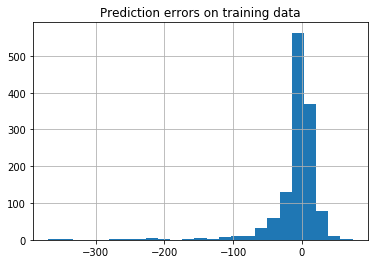

In [11]:
(grid_svr.predict(X_train) - y_train['walk']).hist(bins=25)

plt.title("Prediction errors on training data")
plt.show()

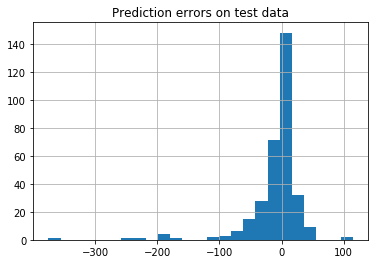

In [12]:
(grid_svr.predict(X_test) - y_test['walk']).hist(bins=25)
plt.title("Prediction errors on test data")
plt.show()

Let's look at the predictions for which the error was very large (> 150)

In [13]:
ERROR_ABS_THRESHOLD_VALUE = 150

X_test["svr_abs_error_walk"] = grid_svr.predict(X_test) - y_test['walk']
X_test["svr_large_error_walk"] = abs(X_test["svr_abs_error_walk"]) >= ERROR_ABS_THRESHOLD_VALUE

In [14]:
X_test[X_test["svr_large_error_walk"]].sort_values(by="svr_abs_error_walk", ascending=True)

,verh,morf,wegcat,is_natw,segm_wall,segm_building,segm_sky,segm_tree,segm_road,segm_grass,...,morf_110_2000,morf_111_2000,morf_112_2000,morf_113_2000,morf_114_2000,morf_116_2000,morf_-8_2000,morf_125_2000,svr_abs_error_walk,svr_large_error_walk
109,1,103,L3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,22,9,0,1,-374.915341,True
534,1,103,L3,0.0,0.000000,0.527833,0.084952,0.002382,0.168837,0.000000,...,1,0,0,4,24,0,0,1,-245.696064,True
275,1,103,L3,0.0,0.005646,0.380936,0.142849,0.041542,0.285098,0.000000,...,0,3,0,4,22,6,0,0,-234.589919,True
590,1,103,L3,0.0,0.001346,0.139713,0.253246,0.120084,0.189863,0.018296,...,1,0,0,7,15,2,0,0,-193.979330,True
259,1,103,L3,0.0,0.000245,0.588709,0.060893,0.008057,0.113571,0.000292,...,0,11,0,21,90,0,0,0,-189.177274,True
602,1,103,L3,0.0,0.000000,0.482770,0.123713,0.007279,0.251050,0.000000,...,0,1,0,19,20,7,0,0,-188.993895,True
237,1,103,L3,0.0,0.000109,0.433417,0.102933,0.050871,0.260674,0.001110,...,7,1,0,2,27,24,0,0,-183.855822,True
694,1,103,L2,0.0,0.000264,0.114043,0.119587,0.307146,0.307816,0.003967,...,0,0,0,0,4,4,0,0,-160.837190,True


# Automatic Relevance Detection

In [30]:
pipe_ard = Pipeline(
    [
        _pipeline_def,
        ('est', ARDRegression())
    ]
)

# set parameters to optimize
params = {
    'est__n_iter': [50, 100, 200, 300, 500],
    'est__tol': [1e-5, 1e-3, 1e-2],
    'est__alpha_1': [1e-6],
    'est__alpha_2': [1e-6],
    'est__lambda_1': [1e-2, 1e-4, 1e-6],
    'est__lambda_2': [1e-2, 1e-4, 1e-6],
    'est__threshold_lambda': [1e3, 1e4, 1e6],
}


grid_ard = GridSearchCV(pipe_ard, params, scoring="neg_mean_absolute_error", cv=10, verbose=3)
model_ard = grid_ard.fit(X_train, y_train['walk'])

Fitting 10 folds for each of 405 candidates, totalling 4050 fits
[CV 1/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=50, est__threshold_lambda=1000.0, est__tol=1e-05;, score=-25.305 total time=   1.7s
[CV 2/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=50, est__threshold_lambda=1000.0, est__tol=1e-05;, score=-24.075 total time=   1.8s
[CV 3/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=50, est__threshold_lambda=1000.0, est__tol=1e-05;, score=-23.966 total time=   1.9s
[CV 4/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=50, est__threshold_lambda=1000.0, est__tol=1e-05;, score=-21.873 total time=   1.4s
[CV 5/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=50, est__threshold_lambda=1000.0, est__tol=1e-05;, score=-23.394 tota

[CV 4/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=50, est__threshold_lambda=10000.0, est__tol=0.001;, score=-21.873 total time=   1.8s
[CV 5/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=50, est__threshold_lambda=10000.0, est__tol=0.001;, score=-23.394 total time=   1.9s
[CV 6/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=50, est__threshold_lambda=10000.0, est__tol=0.001;, score=-28.310 total time=   1.9s
[CV 7/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=50, est__threshold_lambda=10000.0, est__tol=0.001;, score=-25.733 total time=   1.9s
[CV 8/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=50, est__threshold_lambda=10000.0, est__tol=0.001;, score=-21.766 total time=   1.9s
[CV 9/10] END est__alpha_1=1e-06, est__alpha_

[CV 7/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=50, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-25.733 total time=   1.8s
[CV 8/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=50, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-21.766 total time=   1.8s
[CV 9/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=50, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-20.029 total time=   1.8s
[CV 10/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=50, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-22.628 total time=   2.2s
[CV 1/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=100, est__threshold_lambda=1000.0, est__tol=1e-05;, score=-25.315 total time=   3.8s
[CV 2/10] END est__alpha_1=1e-06, est__a

[CV 10/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=100, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-22.608 total time=   4.1s
[CV 1/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=100, est__threshold_lambda=10000.0, est__tol=0.001;, score=-25.315 total time=   3.8s
[CV 2/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=100, est__threshold_lambda=10000.0, est__tol=0.001;, score=-24.080 total time=   4.0s
[CV 3/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=100, est__threshold_lambda=10000.0, est__tol=0.001;, score=-23.930 total time=   3.8s
[CV 4/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=100, est__threshold_lambda=10000.0, est__tol=0.001;, score=-21.872 total time=   2.6s
[CV 5/10] END est__alpha_1=1e-06, est__

[CV 3/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=100, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-23.930 total time=   3.7s
[CV 4/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=100, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-21.872 total time=   2.2s
[CV 5/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=100, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-23.571 total time=   3.6s
[CV 6/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=100, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-28.321 total time=   4.1s
[CV 7/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=100, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-25.741 total time=   3.8s
[CV 8/10] END est__alpha_1=1e-06, e

[CV 6/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=200, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-28.299 total time=   7.3s
[CV 7/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=200, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-25.742 total time=   6.6s
[CV 8/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=200, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-21.814 total time=   6.4s
[CV 9/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=200, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-20.026 total time=   3.8s
[CV 10/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=200, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-22.608 total time=   6.4s
[CV 1/10] END est__alpha_1=1e-06, est__

[CV 9/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=200, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-20.026 total time=   3.0s
[CV 10/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=200, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-22.608 total time=   4.7s
[CV 1/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=200, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-25.315 total time=   4.1s
[CV 2/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=200, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-24.080 total time=   4.0s
[CV 3/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=200, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-23.930 total time=   3.7s
[CV 4/10] END est__alpha_1=1e-06

[CV 2/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=300, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-24.081 total time=   8.3s
[CV 3/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=300, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-23.930 total time=   5.1s
[CV 4/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=300, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-21.872 total time=   3.3s
[CV 5/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=300, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-23.596 total time=  10.3s
[CV 6/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=300, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-28.299 total time=  11.6s
[CV 7/10] END est__alpha_1=1e-06, est__a

[CV 5/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=300, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-23.571 total time=   4.2s
[CV 6/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=300, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-28.299 total time=   6.9s
[CV 7/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=300, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-25.742 total time=   4.6s
[CV 8/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=300, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-21.814 total time=   5.4s
[CV 9/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=300, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-20.026 total time=   2.9s
[CV 10/10] END est__alpha_1=1e

[CV 8/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=500, est__threshold_lambda=1000.0, est__tol=0.01;, score=-21.814 total time=   4.8s
[CV 9/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=500, est__threshold_lambda=1000.0, est__tol=0.01;, score=-20.026 total time=   2.3s
[CV 10/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=500, est__threshold_lambda=1000.0, est__tol=0.01;, score=-22.608 total time=   3.7s
[CV 1/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=500, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-25.315 total time=   6.4s
[CV 2/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=500, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-24.081 total time=   8.0s
[CV 3/10] END est__alpha_1=1e-06, est__alpha_

[CV 1/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=500, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-25.315 total time=   5.0s
[CV 2/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=500, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-24.081 total time=   5.5s
[CV 3/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=500, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-23.930 total time=   4.3s
[CV 4/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=500, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-21.872 total time=   2.8s
[CV 5/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.01, est__n_iter=500, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-23.571 total time=   4.2s
[CV 6/10] END est__alpha_1=1e-

[CV 4/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.0001, est__n_iter=50, est__threshold_lambda=1000.0, est__tol=0.01;, score=-20.889 total time=   1.0s
[CV 5/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.0001, est__n_iter=50, est__threshold_lambda=1000.0, est__tol=0.01;, score=-22.296 total time=   1.7s
[CV 6/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.0001, est__n_iter=50, est__threshold_lambda=1000.0, est__tol=0.01;, score=-24.776 total time=   2.1s
[CV 7/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.0001, est__n_iter=50, est__threshold_lambda=1000.0, est__tol=0.01;, score=-22.879 total time=   2.1s
[CV 8/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.0001, est__n_iter=50, est__threshold_lambda=1000.0, est__tol=0.01;, score=-20.989 total time=   1.2s
[CV 9/10] END est__alpha_1=1e-06, est__alpha_

[CV 7/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.0001, est__n_iter=50, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-22.879 total time=   2.0s
[CV 8/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.0001, est__n_iter=50, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-20.989 total time=   1.5s
[CV 9/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.0001, est__n_iter=50, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-17.957 total time=   2.1s
[CV 10/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.0001, est__n_iter=50, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-21.731 total time=   1.8s
[CV 1/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.0001, est__n_iter=50, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-23.268 total time=   1.3s
[CV 2/10] END est__alpha

[CV 10/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.0001, est__n_iter=100, est__threshold_lambda=1000.0, est__tol=0.001;, score=-21.731 total time=   1.8s
[CV 1/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.0001, est__n_iter=100, est__threshold_lambda=1000.0, est__tol=0.01;, score=-23.268 total time=   1.3s
[CV 2/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.0001, est__n_iter=100, est__threshold_lambda=1000.0, est__tol=0.01;, score=-24.294 total time=   1.4s
[CV 3/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.0001, est__n_iter=100, est__threshold_lambda=1000.0, est__tol=0.01;, score=-23.766 total time=   3.6s
[CV 4/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.0001, est__n_iter=100, est__threshold_lambda=1000.0, est__tol=0.01;, score=-20.889 total time=   1.0s
[CV 5/10] END est__alpha_1=1e-06, est_

[CV 3/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.0001, est__n_iter=100, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-23.766 total time=   4.3s
[CV 4/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.0001, est__n_iter=100, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-20.889 total time=   1.7s
[CV 5/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.0001, est__n_iter=100, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-22.296 total time=   2.7s
[CV 6/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.0001, est__n_iter=100, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-24.776 total time=   4.0s
[CV 7/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.0001, est__n_iter=100, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-22.879 total time=   3.8s
[CV 8/10] END est__a

[CV 6/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.0001, est__n_iter=200, est__threshold_lambda=1000.0, est__tol=0.001;, score=-24.776 total time=   3.2s
[CV 7/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.0001, est__n_iter=200, est__threshold_lambda=1000.0, est__tol=0.001;, score=-22.879 total time=   3.6s
[CV 8/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.0001, est__n_iter=200, est__threshold_lambda=1000.0, est__tol=0.001;, score=-20.989 total time=   1.4s
[CV 9/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.0001, est__n_iter=200, est__threshold_lambda=1000.0, est__tol=0.001;, score=-17.940 total time=   2.9s
[CV 10/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.0001, est__n_iter=200, est__threshold_lambda=1000.0, est__tol=0.001;, score=-21.731 total time=   2.0s
[CV 1/10] END est__alpha_1=1e-06, 

[CV 9/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.0001, est__n_iter=200, est__threshold_lambda=10000.0, est__tol=0.01;, score=-17.940 total time=   3.0s
[CV 10/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.0001, est__n_iter=200, est__threshold_lambda=10000.0, est__tol=0.01;, score=-21.731 total time=   1.9s
[CV 1/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.0001, est__n_iter=200, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-23.268 total time=   2.1s
[CV 2/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.0001, est__n_iter=200, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-24.294 total time=   2.8s
[CV 3/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.0001, est__n_iter=200, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-23.765 total time=   6.2s
[CV 4/10] END est__alpha_

[CV 2/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.0001, est__n_iter=300, est__threshold_lambda=1000.0, est__tol=0.001;, score=-24.294 total time=   1.6s
[CV 3/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.0001, est__n_iter=300, est__threshold_lambda=1000.0, est__tol=0.001;, score=-23.765 total time=   5.0s
[CV 4/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.0001, est__n_iter=300, est__threshold_lambda=1000.0, est__tol=0.001;, score=-20.889 total time=   1.3s
[CV 5/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.0001, est__n_iter=300, est__threshold_lambda=1000.0, est__tol=0.001;, score=-22.296 total time=   2.1s
[CV 6/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.0001, est__n_iter=300, est__threshold_lambda=1000.0, est__tol=0.001;, score=-24.776 total time=   3.2s
[CV 7/10] END est__alpha_1=1e-06, e

[CV 5/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.0001, est__n_iter=300, est__threshold_lambda=10000.0, est__tol=0.01;, score=-22.296 total time=   1.7s
[CV 6/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.0001, est__n_iter=300, est__threshold_lambda=10000.0, est__tol=0.01;, score=-24.776 total time=   2.6s
[CV 7/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.0001, est__n_iter=300, est__threshold_lambda=10000.0, est__tol=0.01;, score=-22.879 total time=   3.5s
[CV 8/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.0001, est__n_iter=300, est__threshold_lambda=10000.0, est__tol=0.01;, score=-20.989 total time=   1.3s
[CV 9/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.0001, est__n_iter=300, est__threshold_lambda=10000.0, est__tol=0.01;, score=-17.940 total time=   2.7s
[CV 10/10] END est__alpha_1=1e-06, 

[CV 8/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.0001, est__n_iter=500, est__threshold_lambda=1000.0, est__tol=1e-05;, score=-20.989 total time=   1.7s
[CV 9/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.0001, est__n_iter=500, est__threshold_lambda=1000.0, est__tol=1e-05;, score=-17.940 total time=   3.3s
[CV 10/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.0001, est__n_iter=500, est__threshold_lambda=1000.0, est__tol=1e-05;, score=-21.731 total time=   2.8s
[CV 1/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.0001, est__n_iter=500, est__threshold_lambda=1000.0, est__tol=0.001;, score=-23.268 total time=   1.5s
[CV 2/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.0001, est__n_iter=500, est__threshold_lambda=1000.0, est__tol=0.001;, score=-24.294 total time=   1.6s
[CV 3/10] END est__alpha_1=1e-06, 

[CV 1/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.0001, est__n_iter=500, est__threshold_lambda=10000.0, est__tol=0.01;, score=-23.268 total time=   1.3s
[CV 2/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.0001, est__n_iter=500, est__threshold_lambda=10000.0, est__tol=0.01;, score=-24.294 total time=   1.4s
[CV 3/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.0001, est__n_iter=500, est__threshold_lambda=10000.0, est__tol=0.01;, score=-23.765 total time=   4.5s
[CV 4/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.0001, est__n_iter=500, est__threshold_lambda=10000.0, est__tol=0.01;, score=-20.889 total time=   1.1s
[CV 5/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=0.0001, est__n_iter=500, est__threshold_lambda=10000.0, est__tol=0.01;, score=-22.296 total time=   1.8s
[CV 6/10] END est__alpha_1=1e-06, e

[CV 4/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=50, est__threshold_lambda=1000.0, est__tol=1e-05;, score=-20.889 total time=   0.1s
[CV 5/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=50, est__threshold_lambda=1000.0, est__tol=1e-05;, score=-22.295 total time=   0.1s
[CV 6/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=50, est__threshold_lambda=1000.0, est__tol=1e-05;, score=-24.775 total time=   0.1s
[CV 7/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=50, est__threshold_lambda=1000.0, est__tol=1e-05;, score=-22.879 total time=   0.1s
[CV 8/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=50, est__threshold_lambda=1000.0, est__tol=1e-05;, score=-20.989 total time=   0.1s
[CV 9/10] END est__alpha_1=1e-06, est__alpha_

[CV 7/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=50, est__threshold_lambda=10000.0, est__tol=0.001;, score=-22.879 total time=   0.3s
[CV 8/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=50, est__threshold_lambda=10000.0, est__tol=0.001;, score=-20.989 total time=   0.2s
[CV 9/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=50, est__threshold_lambda=10000.0, est__tol=0.001;, score=-17.956 total time=   0.2s
[CV 10/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=50, est__threshold_lambda=10000.0, est__tol=0.001;, score=-21.731 total time=   0.2s
[CV 1/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=50, est__threshold_lambda=10000.0, est__tol=0.01;, score=-23.268 total time=   0.2s
[CV 2/10] END est__alpha_1=1e-06, est__a

[CV 10/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=50, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-21.731 total time=   2.1s
[CV 1/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=100, est__threshold_lambda=1000.0, est__tol=1e-05;, score=-23.268 total time=   0.2s
[CV 2/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=100, est__threshold_lambda=1000.0, est__tol=1e-05;, score=-24.294 total time=   0.2s
[CV 3/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=100, est__threshold_lambda=1000.0, est__tol=1e-05;, score=-23.764 total time=   0.4s
[CV 4/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=100, est__threshold_lambda=1000.0, est__tol=1e-05;, score=-20.889 total time=   0.2s
[CV 5/10] END est__alpha_1=1e-06, est_

[CV 3/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=100, est__threshold_lambda=10000.0, est__tol=0.001;, score=-23.764 total time=   0.4s
[CV 4/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=100, est__threshold_lambda=10000.0, est__tol=0.001;, score=-20.889 total time=   0.2s
[CV 5/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=100, est__threshold_lambda=10000.0, est__tol=0.001;, score=-22.295 total time=   0.3s
[CV 6/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=100, est__threshold_lambda=10000.0, est__tol=0.001;, score=-24.775 total time=   0.3s
[CV 7/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=100, est__threshold_lambda=10000.0, est__tol=0.001;, score=-22.879 total time=   0.4s
[CV 8/10] END est__alpha_1=1e-06, e

[CV 6/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=100, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-24.775 total time=   2.9s
[CV 7/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=100, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-22.879 total time=   3.4s
[CV 8/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=100, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-20.989 total time=   1.9s
[CV 9/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=100, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-17.939 total time=   3.2s
[CV 10/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=100, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-21.731 total time=   2.0s
[CV 1/10] END est__alpha_1=1e

[CV 9/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=200, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-17.939 total time=   0.4s
[CV 10/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=200, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-21.731 total time=   0.3s
[CV 1/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=200, est__threshold_lambda=10000.0, est__tol=0.001;, score=-23.268 total time=   0.2s
[CV 2/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=200, est__threshold_lambda=10000.0, est__tol=0.001;, score=-24.294 total time=   0.3s
[CV 3/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=200, est__threshold_lambda=10000.0, est__tol=0.001;, score=-23.765 total time=   0.5s
[CV 4/10] END est__alpha_1=1e-06, 

[CV 2/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=200, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-24.295 total time=   2.1s
[CV 3/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=200, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-23.766 total time=   4.8s
[CV 4/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=200, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-20.889 total time=   1.1s
[CV 5/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=200, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-22.295 total time=   1.2s
[CV 6/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=200, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-24.775 total time=   2.6s
[CV 7/10] END est__alpha_1=1e-

[CV 5/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=300, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-22.295 total time=   0.3s
[CV 6/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=300, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-24.775 total time=   0.4s
[CV 7/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=300, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-22.879 total time=   0.4s
[CV 8/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=300, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-20.989 total time=   0.2s
[CV 9/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=300, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-17.939 total time=   0.3s
[CV 10/10] END est__alpha_1=1e-06, 

[CV 8/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=300, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-20.989 total time=   1.6s
[CV 9/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=300, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-17.939 total time=   2.9s
[CV 10/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=300, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-21.731 total time=   2.1s
[CV 1/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=300, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-23.268 total time=   1.6s
[CV 2/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=300, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-24.295 total time=   1.9s
[CV 3/10] END est__alpha_1

[CV 1/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=500, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-23.268 total time=   0.3s
[CV 2/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=500, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-24.294 total time=   0.3s
[CV 3/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=500, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-23.765 total time=   0.6s
[CV 4/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=500, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-20.889 total time=   0.2s
[CV 5/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=500, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-22.295 total time=   0.3s
[CV 6/10] END est__alpha_1=1e-06, e

[CV 4/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=500, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-20.889 total time=   1.3s
[CV 5/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=500, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-22.295 total time=   1.4s
[CV 6/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=500, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-24.775 total time=   3.2s
[CV 7/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=500, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-22.879 total time=   3.2s
[CV 8/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.01, est__lambda_2=1e-06, est__n_iter=500, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-20.989 total time=   1.6s
[CV 9/10] END est__alpha_

[CV 7/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.01, est__n_iter=50, est__threshold_lambda=1000.0, est__tol=0.01;, score=-25.631 total time=   1.7s
[CV 8/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.01, est__n_iter=50, est__threshold_lambda=1000.0, est__tol=0.01;, score=-23.013 total time=   1.7s
[CV 9/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.01, est__n_iter=50, est__threshold_lambda=1000.0, est__tol=0.01;, score=-19.834 total time=   1.6s
[CV 10/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.01, est__n_iter=50, est__threshold_lambda=1000.0, est__tol=0.01;, score=-22.472 total time=   1.6s
[CV 1/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.01, est__n_iter=50, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-25.984 total time=   1.6s
[CV 2/10] END est__alpha_1=1e-06, est__alp

[CV 10/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.01, est__n_iter=50, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-22.472 total time=   1.7s
[CV 1/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.01, est__n_iter=50, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-25.984 total time=   1.7s
[CV 2/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.01, est__n_iter=50, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-23.967 total time=   1.6s
[CV 3/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.01, est__n_iter=50, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-23.837 total time=   1.8s
[CV 4/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.01, est__n_iter=50, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-21.295 total time=   1.7s
[CV 5/10] END est__alpha

[CV 3/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.01, est__n_iter=100, est__threshold_lambda=1000.0, est__tol=0.01;, score=-23.944 total time=   3.6s
[CV 4/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.01, est__n_iter=100, est__threshold_lambda=1000.0, est__tol=0.01;, score=-21.288 total time=   3.3s
[CV 5/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.01, est__n_iter=100, est__threshold_lambda=1000.0, est__tol=0.01;, score=-25.000 total time=   3.0s
[CV 6/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.01, est__n_iter=100, est__threshold_lambda=1000.0, est__tol=0.01;, score=-28.511 total time=   3.2s
[CV 7/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.01, est__n_iter=100, est__threshold_lambda=1000.0, est__tol=0.01;, score=-25.716 total time=   3.4s
[CV 8/10] END est__alpha_1=1e-06, est__a

[CV 6/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.01, est__n_iter=100, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-28.511 total time=   3.0s
[CV 7/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.01, est__n_iter=100, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-25.716 total time=   3.2s
[CV 8/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.01, est__n_iter=100, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-23.005 total time=   3.4s
[CV 9/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.01, est__n_iter=100, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-19.832 total time=   3.4s
[CV 10/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.01, est__n_iter=100, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-22.450 total time=   3.4s
[CV 1/10] END est__

[CV 9/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.01, est__n_iter=200, est__threshold_lambda=1000.0, est__tol=0.001;, score=-19.832 total time=   6.4s
[CV 10/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.01, est__n_iter=200, est__threshold_lambda=1000.0, est__tol=0.001;, score=-22.451 total time=   6.9s
[CV 1/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.01, est__n_iter=200, est__threshold_lambda=1000.0, est__tol=0.01;, score=-26.001 total time=   5.3s
[CV 2/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.01, est__n_iter=200, est__threshold_lambda=1000.0, est__tol=0.01;, score=-23.918 total time=   6.8s
[CV 3/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.01, est__n_iter=200, est__threshold_lambda=1000.0, est__tol=0.01;, score=-23.942 total time=   4.3s
[CV 4/10] END est__alpha_1=1e-06, est

[CV 2/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.01, est__n_iter=200, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-23.918 total time=   6.3s
[CV 3/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.01, est__n_iter=200, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-23.942 total time=   6.7s
[CV 4/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.01, est__n_iter=200, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-21.287 total time=   6.5s
[CV 5/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.01, est__n_iter=200, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-25.000 total time=   6.4s
[CV 6/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.01, est__n_iter=200, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-28.511 total time=   6.3s
[CV 7/10] END est__a

[CV 5/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.01, est__n_iter=300, est__threshold_lambda=1000.0, est__tol=0.001;, score=-25.000 total time=   4.7s
[CV 6/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.01, est__n_iter=300, est__threshold_lambda=1000.0, est__tol=0.001;, score=-28.511 total time=   5.9s
[CV 7/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.01, est__n_iter=300, est__threshold_lambda=1000.0, est__tol=0.001;, score=-25.709 total time=   9.6s
[CV 8/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.01, est__n_iter=300, est__threshold_lambda=1000.0, est__tol=0.001;, score=-23.008 total time=   9.5s
[CV 9/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.01, est__n_iter=300, est__threshold_lambda=1000.0, est__tol=0.001;, score=-19.832 total time=   6.4s
[CV 10/10] END est__alpha_1=1e-06, 

[CV 8/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.01, est__n_iter=300, est__threshold_lambda=10000.0, est__tol=0.01;, score=-23.008 total time=   4.4s
[CV 9/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.01, est__n_iter=300, est__threshold_lambda=10000.0, est__tol=0.01;, score=-19.832 total time=   4.7s
[CV 10/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.01, est__n_iter=300, est__threshold_lambda=10000.0, est__tol=0.01;, score=-22.450 total time=   7.9s
[CV 1/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.01, est__n_iter=300, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-26.001 total time=  12.1s
[CV 2/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.01, est__n_iter=300, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-23.919 total time=  11.0s
[CV 3/10] END est__alpha_1=1

[CV 1/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.01, est__n_iter=500, est__threshold_lambda=1000.0, est__tol=0.001;, score=-26.001 total time=  10.6s
[CV 2/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.01, est__n_iter=500, est__threshold_lambda=1000.0, est__tol=0.001;, score=-23.919 total time=  18.1s
[CV 3/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.01, est__n_iter=500, est__threshold_lambda=1000.0, est__tol=0.001;, score=-23.942 total time=   6.6s
[CV 4/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.01, est__n_iter=500, est__threshold_lambda=1000.0, est__tol=0.001;, score=-21.286 total time=  10.9s
[CV 5/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.01, est__n_iter=500, est__threshold_lambda=1000.0, est__tol=0.001;, score=-25.000 total time=   5.4s
[CV 6/10] END est__alpha_1=1e-06, e

[CV 4/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.01, est__n_iter=500, est__threshold_lambda=10000.0, est__tol=0.01;, score=-21.286 total time=   7.9s
[CV 5/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.01, est__n_iter=500, est__threshold_lambda=10000.0, est__tol=0.01;, score=-25.000 total time=   3.7s
[CV 6/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.01, est__n_iter=500, est__threshold_lambda=10000.0, est__tol=0.01;, score=-28.511 total time=   4.5s
[CV 7/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.01, est__n_iter=500, est__threshold_lambda=10000.0, est__tol=0.01;, score=-25.709 total time=   8.2s
[CV 8/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.01, est__n_iter=500, est__threshold_lambda=10000.0, est__tol=0.01;, score=-23.008 total time=   4.6s
[CV 9/10] END est__alpha_1=1e-06, e

[CV 6/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=50, est__threshold_lambda=1000.0, est__tol=1e-05;, score=-28.407 total time=   2.1s
[CV 7/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=50, est__threshold_lambda=1000.0, est__tol=1e-05;, score=-25.521 total time=   1.8s
[CV 8/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=50, est__threshold_lambda=1000.0, est__tol=1e-05;, score=-21.963 total time=   1.9s
[CV 9/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=50, est__threshold_lambda=1000.0, est__tol=1e-05;, score=-20.383 total time=   2.0s
[CV 10/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=50, est__threshold_lambda=1000.0, est__tol=1e-05;, score=-23.227 total time=   1.9s
[CV 1/10] END est__alpha_1=1e

[CV 9/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=50, est__threshold_lambda=10000.0, est__tol=0.001;, score=-20.383 total time=   1.8s
[CV 10/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=50, est__threshold_lambda=10000.0, est__tol=0.001;, score=-23.227 total time=   1.8s
[CV 1/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=50, est__threshold_lambda=10000.0, est__tol=0.01;, score=-25.958 total time=   1.8s
[CV 2/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=50, est__threshold_lambda=10000.0, est__tol=0.01;, score=-24.057 total time=   2.0s
[CV 3/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=50, est__threshold_lambda=10000.0, est__tol=0.01;, score=-23.874 total time=   1.9s
[CV 4/10] END est__alpha_1=

[CV 1/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=100, est__threshold_lambda=1000.0, est__tol=1e-05;, score=-26.008 total time=   3.4s
[CV 2/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=100, est__threshold_lambda=1000.0, est__tol=1e-05;, score=-24.074 total time=   3.8s
[CV 3/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=100, est__threshold_lambda=1000.0, est__tol=1e-05;, score=-23.772 total time=   3.6s
[CV 4/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=100, est__threshold_lambda=1000.0, est__tol=1e-05;, score=-21.694 total time=   3.4s
[CV 5/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=100, est__threshold_lambda=1000.0, est__tol=1e-05;, score=-24.992 total time=   3.5s
[CV 6/10] END est__alpha_

[CV 3/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=100, est__threshold_lambda=10000.0, est__tol=0.001;, score=-23.772 total time=   3.9s
[CV 4/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=100, est__threshold_lambda=10000.0, est__tol=0.001;, score=-21.694 total time=   3.8s
[CV 5/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=100, est__threshold_lambda=10000.0, est__tol=0.001;, score=-24.992 total time=   3.8s
[CV 6/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=100, est__threshold_lambda=10000.0, est__tol=0.001;, score=-28.420 total time=   3.9s
[CV 7/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=100, est__threshold_lambda=10000.0, est__tol=0.001;, score=-25.642 total time=   3.9s
[CV 8/10] END est__a

[CV 5/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=100, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-24.992 total time=   3.5s
[CV 6/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=100, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-28.420 total time=   3.5s
[CV 7/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=100, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-25.642 total time=   3.5s
[CV 8/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=100, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-21.819 total time=   3.5s
[CV 9/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=100, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-20.391 total time=   3.4s
[CV 10/10] END 

[CV 7/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=200, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-25.690 total time=   6.6s
[CV 8/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=200, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-21.817 total time=   7.2s
[CV 9/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=200, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-20.397 total time=   7.1s
[CV 10/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=200, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-23.226 total time=   6.7s
[CV 1/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=200, est__threshold_lambda=10000.0, est__tol=0.001;, score=-26.011 total time=   6.7s
[CV 2/10] END est__

[CV 9/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=200, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-20.397 total time=   5.5s
[CV 10/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=200, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-23.226 total time=   5.2s
[CV 1/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=200, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-26.011 total time=   5.7s
[CV 2/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=200, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-23.953 total time=   5.8s
[CV 3/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=200, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-23.771 total time=   4.8s
[CV 4/10] EN

[CV 1/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=300, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-26.014 total time=   8.4s
[CV 2/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=300, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-23.936 total time=   8.6s
[CV 3/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=300, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-23.771 total time=   8.3s
[CV 4/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=300, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-21.693 total time=   8.2s
[CV 5/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=300, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-24.993 total time=   8.5s
[CV 6/10] END est__a

[CV 3/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=300, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-23.771 total time=   8.0s
[CV 4/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=300, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-21.693 total time=   7.3s
[CV 5/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=300, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-24.993 total time=   6.5s
[CV 6/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=300, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-28.422 total time=   8.4s
[CV 7/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=300, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-25.689 total time=   8.5s
[CV 8/10] 

[CV 5/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=500, est__threshold_lambda=1000.0, est__tol=0.01;, score=-24.993 total time=   5.2s
[CV 6/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=500, est__threshold_lambda=1000.0, est__tol=0.01;, score=-28.422 total time=   8.5s
[CV 7/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=500, est__threshold_lambda=1000.0, est__tol=0.01;, score=-25.673 total time=  14.4s
[CV 8/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=500, est__threshold_lambda=1000.0, est__tol=0.01;, score=-21.818 total time=   3.6s
[CV 9/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=500, est__threshold_lambda=1000.0, est__tol=0.01;, score=-20.398 total time=   9.5s
[CV 10/10] END est__alpha_1=1e

[CV 7/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=500, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-25.673 total time=  13.6s
[CV 8/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=500, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-21.817 total time=   6.3s
[CV 9/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=500, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-20.398 total time=  12.4s
[CV 10/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=500, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-23.226 total time=   7.6s
[CV 1/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=0.0001, est__n_iter=500, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-26.014 total time=   8.3s
[CV 2/10]

[CV 9/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=50, est__threshold_lambda=1000.0, est__tol=0.001;, score=-20.516 total time=   1.6s
[CV 10/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=50, est__threshold_lambda=1000.0, est__tol=0.001;, score=-22.174 total time=   1.8s
[CV 1/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=50, est__threshold_lambda=1000.0, est__tol=0.01;, score=-25.474 total time=   1.7s
[CV 2/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=50, est__threshold_lambda=1000.0, est__tol=0.01;, score=-23.819 total time=   1.8s
[CV 3/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=50, est__threshold_lambda=1000.0, est__tol=0.01;, score=-24.017 total time=   1.8s
[CV 4/10] END est__alpha_1=1e-06, est

[CV 2/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=50, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-23.819 total time=   1.7s
[CV 3/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=50, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-24.017 total time=   1.6s
[CV 4/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=50, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-21.850 total time=   1.8s
[CV 5/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=50, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-25.304 total time=   1.6s
[CV 6/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=50, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-28.271 total time=   1.5s
[CV 7/10] END est__a

[CV 4/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=100, est__threshold_lambda=1000.0, est__tol=0.001;, score=-21.856 total time=   2.9s
[CV 5/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=100, est__threshold_lambda=1000.0, est__tol=0.001;, score=-25.585 total time=   2.9s
[CV 6/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=100, est__threshold_lambda=1000.0, est__tol=0.001;, score=-28.280 total time=   2.9s
[CV 7/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=100, est__threshold_lambda=1000.0, est__tol=0.001;, score=-25.560 total time=   2.9s
[CV 8/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=100, est__threshold_lambda=1000.0, est__tol=0.001;, score=-21.589 total time=   2.9s
[CV 9/10] END est__alpha_1=1e-

[CV 7/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=100, est__threshold_lambda=10000.0, est__tol=0.01;, score=-25.560 total time=   3.0s
[CV 8/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=100, est__threshold_lambda=10000.0, est__tol=0.01;, score=-21.654 total time=   3.0s
[CV 9/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=100, est__threshold_lambda=10000.0, est__tol=0.01;, score=-20.519 total time=   3.1s
[CV 10/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=100, est__threshold_lambda=10000.0, est__tol=0.01;, score=-22.307 total time=   3.2s
[CV 1/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=100, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-25.470 total time=   3.2s
[CV 2/10] END est__alpha_1

[CV 9/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=200, est__threshold_lambda=1000.0, est__tol=1e-05;, score=-20.530 total time=   6.7s
[CV 10/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=200, est__threshold_lambda=1000.0, est__tol=1e-05;, score=-22.308 total time=   6.4s
[CV 1/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=200, est__threshold_lambda=1000.0, est__tol=0.001;, score=-25.473 total time=   5.0s
[CV 2/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=200, est__threshold_lambda=1000.0, est__tol=0.001;, score=-23.822 total time=   4.6s
[CV 3/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=200, est__threshold_lambda=1000.0, est__tol=0.001;, score=-23.935 total time=   6.3s
[CV 4/10] END est__alpha_1=1e

[CV 2/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=200, est__threshold_lambda=10000.0, est__tol=0.01;, score=-23.822 total time=   3.6s
[CV 3/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=200, est__threshold_lambda=10000.0, est__tol=0.01;, score=-23.935 total time=   6.2s
[CV 4/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=200, est__threshold_lambda=10000.0, est__tol=0.01;, score=-21.857 total time=   4.5s
[CV 5/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=200, est__threshold_lambda=10000.0, est__tol=0.01;, score=-25.586 total time=   4.4s
[CV 6/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=200, est__threshold_lambda=10000.0, est__tol=0.01;, score=-28.285 total time=   5.9s
[CV 7/10] END est__alpha_1=1e-

[CV 4/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=300, est__threshold_lambda=1000.0, est__tol=1e-05;, score=-21.858 total time=   8.8s
[CV 5/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=300, est__threshold_lambda=1000.0, est__tol=1e-05;, score=-25.586 total time=   7.7s
[CV 6/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=300, est__threshold_lambda=1000.0, est__tol=1e-05;, score=-28.285 total time=   9.2s
[CV 7/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=300, est__threshold_lambda=1000.0, est__tol=1e-05;, score=-25.560 total time=   4.8s
[CV 8/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=300, est__threshold_lambda=1000.0, est__tol=1e-05;, score=-21.599 total time=   9.5s
[CV 9/10] END est__alpha_1=1e-

[CV 7/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=300, est__threshold_lambda=10000.0, est__tol=0.001;, score=-25.560 total time=   3.7s
[CV 8/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=300, est__threshold_lambda=10000.0, est__tol=0.001;, score=-21.594 total time=   7.6s
[CV 9/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=300, est__threshold_lambda=10000.0, est__tol=0.001;, score=-20.530 total time=   7.6s
[CV 10/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=300, est__threshold_lambda=10000.0, est__tol=0.001;, score=-22.308 total time=   5.0s
[CV 1/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=300, est__threshold_lambda=10000.0, est__tol=0.01;, score=-25.472 total time=   4.4s
[CV 2/10] END est__alpha_

[CV 9/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=300, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-20.518 total time=   3.6s
[CV 10/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=300, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-22.308 total time=   4.0s
[CV 1/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=500, est__threshold_lambda=1000.0, est__tol=1e-05;, score=-25.473 total time=   7.1s
[CV 2/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=500, est__threshold_lambda=1000.0, est__tol=1e-05;, score=-23.822 total time=   7.3s
[CV 3/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=500, est__threshold_lambda=1000.0, est__tol=1e-05;, score=-23.941 total time=  14.5s
[CV 4/10] END est__alpha_

[CV 2/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=500, est__threshold_lambda=10000.0, est__tol=0.001;, score=-23.822 total time=   4.6s
[CV 3/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=500, est__threshold_lambda=10000.0, est__tol=0.001;, score=-23.941 total time=  15.2s
[CV 4/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=500, est__threshold_lambda=10000.0, est__tol=0.001;, score=-21.858 total time=   6.1s
[CV 5/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=500, est__threshold_lambda=10000.0, est__tol=0.001;, score=-25.586 total time=   6.1s
[CV 6/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=500, est__threshold_lambda=10000.0, est__tol=0.001;, score=-28.285 total time=   7.4s
[CV 7/10] END est__alpha_

[CV 4/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=500, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-21.857 total time=   4.4s
[CV 5/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=500, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-25.586 total time=   4.4s
[CV 6/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=500, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-28.285 total time=   7.0s
[CV 7/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=500, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-25.560 total time=   2.9s
[CV 8/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=0.0001, est__lambda_2=1e-06, est__n_iter=500, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-21.594 total time=   5.6s
[CV 9/10] END est__a

[CV 7/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.01, est__n_iter=50, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-25.641 total time=   1.1s
[CV 8/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.01, est__n_iter=50, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-23.034 total time=   1.2s
[CV 9/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.01, est__n_iter=50, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-19.835 total time=   1.1s
[CV 10/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.01, est__n_iter=50, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-22.472 total time=   1.1s
[CV 1/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.01, est__n_iter=50, est__threshold_lambda=10000.0, est__tol=0.001;, score=-25.986 total time=   1.1s
[CV 2/10] END est__alpha_1=1e-06, est__

[CV 10/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.01, est__n_iter=50, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-22.472 total time=   1.1s
[CV 1/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.01, est__n_iter=50, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-25.986 total time=   1.1s
[CV 2/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.01, est__n_iter=50, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-23.963 total time=   1.2s
[CV 3/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.01, est__n_iter=50, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-23.874 total time=   1.1s
[CV 4/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.01, est__n_iter=50, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-21.295 total time=   1.1s
[CV 5/10] END est__alpha_1=1e-06,

[CV 3/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.01, est__n_iter=100, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-23.945 total time=   2.2s
[CV 4/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.01, est__n_iter=100, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-21.288 total time=   2.2s
[CV 5/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.01, est__n_iter=100, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-25.001 total time=   2.2s
[CV 6/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.01, est__n_iter=100, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-28.514 total time=   2.3s
[CV 7/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.01, est__n_iter=100, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-25.716 total time=   2.8s
[CV 8/10] END est__alpha_1=1e-06, e

[CV 6/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.01, est__n_iter=100, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-28.514 total time=   2.2s
[CV 7/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.01, est__n_iter=100, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-25.716 total time=   2.1s
[CV 8/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.01, est__n_iter=100, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-23.007 total time=   2.3s
[CV 9/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.01, est__n_iter=100, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-19.834 total time=   2.2s
[CV 10/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.01, est__n_iter=100, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-22.449 total time=   2.2s
[CV 1/10] END est__alpha

[CV 9/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.01, est__n_iter=200, est__threshold_lambda=1000.0, est__tol=0.01;, score=-19.833 total time=   4.3s
[CV 10/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.01, est__n_iter=200, est__threshold_lambda=1000.0, est__tol=0.01;, score=-22.450 total time=   4.3s
[CV 1/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.01, est__n_iter=200, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-26.002 total time=   4.3s
[CV 2/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.01, est__n_iter=200, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-23.918 total time=   4.5s
[CV 3/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.01, est__n_iter=200, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-23.943 total time=   4.2s
[CV 4/10] END est__alpha_1=1e-06, est_

[CV 2/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.01, est__n_iter=200, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-23.918 total time=   4.5s
[CV 3/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.01, est__n_iter=200, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-23.943 total time=   4.3s
[CV 4/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.01, est__n_iter=200, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-21.287 total time=   4.3s
[CV 5/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.01, est__n_iter=200, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-25.001 total time=   4.3s
[CV 6/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.01, est__n_iter=200, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-28.514 total time=   4.3s
[CV 7/10] END est__alpha_

[CV 5/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.01, est__n_iter=300, est__threshold_lambda=1000.0, est__tol=0.01;, score=-25.001 total time=   6.0s
[CV 6/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.01, est__n_iter=300, est__threshold_lambda=1000.0, est__tol=0.01;, score=-28.514 total time=   5.3s
[CV 7/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.01, est__n_iter=300, est__threshold_lambda=1000.0, est__tol=0.01;, score=-25.709 total time=   6.4s
[CV 8/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.01, est__n_iter=300, est__threshold_lambda=1000.0, est__tol=0.01;, score=-23.008 total time=   5.7s
[CV 9/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.01, est__n_iter=300, est__threshold_lambda=1000.0, est__tol=0.01;, score=-19.833 total time=   4.9s
[CV 10/10] END est__alpha_1=1e-06, est__alpha

[CV 8/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.01, est__n_iter=300, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-23.008 total time=   6.8s
[CV 9/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.01, est__n_iter=300, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-19.833 total time=   6.4s
[CV 10/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.01, est__n_iter=300, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-22.450 total time=   6.4s
[CV 1/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.01, est__n_iter=300, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-26.002 total time=   6.4s
[CV 2/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.01, est__n_iter=300, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-23.919 total time=   6.8s
[CV 3/10] END est__alpha

[CV 1/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.01, est__n_iter=500, est__threshold_lambda=1000.0, est__tol=0.01;, score=-26.002 total time=   6.9s
[CV 2/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.01, est__n_iter=500, est__threshold_lambda=1000.0, est__tol=0.01;, score=-23.919 total time=   7.5s
[CV 3/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.01, est__n_iter=500, est__threshold_lambda=1000.0, est__tol=0.01;, score=-23.943 total time=   3.9s
[CV 4/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.01, est__n_iter=500, est__threshold_lambda=1000.0, est__tol=0.01;, score=-21.287 total time=   6.1s
[CV 5/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.01, est__n_iter=500, est__threshold_lambda=1000.0, est__tol=0.01;, score=-25.001 total time=   6.1s
[CV 6/10] END est__alpha_1=1e-06, est__alpha_

[CV 4/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.01, est__n_iter=500, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-21.287 total time=  10.7s
[CV 5/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.01, est__n_iter=500, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-25.001 total time=  10.9s
[CV 6/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.01, est__n_iter=500, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-28.514 total time=  10.7s
[CV 7/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.01, est__n_iter=500, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-25.709 total time=  10.7s
[CV 8/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.01, est__n_iter=500, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-23.008 total time=  11.2s
[CV 9/10] END est__alpha_

[CV 7/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=50, est__threshold_lambda=1000.0, est__tol=0.001;, score=-25.608 total time=   1.2s
[CV 8/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=50, est__threshold_lambda=1000.0, est__tol=0.001;, score=-23.078 total time=   1.2s
[CV 9/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=50, est__threshold_lambda=1000.0, est__tol=0.001;, score=-20.383 total time=   1.2s
[CV 10/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=50, est__threshold_lambda=1000.0, est__tol=0.001;, score=-23.227 total time=   1.3s
[CV 1/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=50, est__threshold_lambda=1000.0, est__tol=0.01;, score=-25.966 total time=   1.2s
[CV 2/10] END est__alpha_1=1e-06, e

[CV 10/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=50, est__threshold_lambda=10000.0, est__tol=0.01;, score=-23.227 total time=   1.3s
[CV 1/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=50, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-25.966 total time=   1.2s
[CV 2/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=50, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-24.142 total time=   1.2s
[CV 3/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=50, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-23.682 total time=   1.2s
[CV 4/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=50, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-21.718 total time=   1.2s
[CV 5/10] END est__alp

[CV 2/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=100, est__threshold_lambda=1000.0, est__tol=0.001;, score=-24.053 total time=   2.4s
[CV 3/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=100, est__threshold_lambda=1000.0, est__tol=0.001;, score=-23.774 total time=   2.4s
[CV 4/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=100, est__threshold_lambda=1000.0, est__tol=0.001;, score=-21.693 total time=   2.4s
[CV 5/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=100, est__threshold_lambda=1000.0, est__tol=0.001;, score=-24.992 total time=   2.4s
[CV 6/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=100, est__threshold_lambda=1000.0, est__tol=0.001;, score=-28.427 total time=   2.3s
[CV 7/10] END est__alpha_1=1e-

[CV 5/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=100, est__threshold_lambda=10000.0, est__tol=0.01;, score=-24.992 total time=   2.3s
[CV 6/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=100, est__threshold_lambda=10000.0, est__tol=0.01;, score=-28.427 total time=   2.3s
[CV 7/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=100, est__threshold_lambda=10000.0, est__tol=0.01;, score=-25.675 total time=   2.5s
[CV 8/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=100, est__threshold_lambda=10000.0, est__tol=0.01;, score=-23.000 total time=   2.4s
[CV 9/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=100, est__threshold_lambda=10000.0, est__tol=0.01;, score=-20.394 total time=   2.3s
[CV 10/10] END est__alpha_1=1e

[CV 7/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=200, est__threshold_lambda=1000.0, est__tol=1e-05;, score=-25.740 total time=   4.8s
[CV 8/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=200, est__threshold_lambda=1000.0, est__tol=1e-05;, score=-23.002 total time=   4.9s
[CV 9/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=200, est__threshold_lambda=1000.0, est__tol=1e-05;, score=-20.397 total time=   4.6s
[CV 10/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=200, est__threshold_lambda=1000.0, est__tol=1e-05;, score=-23.225 total time=   4.9s
[CV 1/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=200, est__threshold_lambda=1000.0, est__tol=0.001;, score=-26.015 total time=   4.6s
[CV 2/10] END est__alpha_1=1e

[CV 10/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=200, est__threshold_lambda=10000.0, est__tol=0.001;, score=-23.225 total time=   4.9s
[CV 1/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=200, est__threshold_lambda=10000.0, est__tol=0.01;, score=-26.015 total time=   3.5s
[CV 2/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=200, est__threshold_lambda=10000.0, est__tol=0.01;, score=-23.896 total time=   4.8s
[CV 3/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=200, est__threshold_lambda=10000.0, est__tol=0.01;, score=-23.773 total time=   3.7s
[CV 4/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=200, est__threshold_lambda=10000.0, est__tol=0.01;, score=-21.693 total time=   3.8s
[CV 5/10] END est__alpha_1=1

[CV 2/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=300, est__threshold_lambda=1000.0, est__tol=1e-05;, score=-23.893 total time=   7.1s
[CV 3/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=300, est__threshold_lambda=1000.0, est__tol=1e-05;, score=-23.772 total time=   7.2s
[CV 4/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=300, est__threshold_lambda=1000.0, est__tol=1e-05;, score=-21.693 total time=   7.2s
[CV 5/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=300, est__threshold_lambda=1000.0, est__tol=1e-05;, score=-24.993 total time=   7.0s
[CV 6/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=300, est__threshold_lambda=1000.0, est__tol=1e-05;, score=-28.428 total time=   6.9s
[CV 7/10] END est__alpha_1=1e-

[CV 5/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=300, est__threshold_lambda=10000.0, est__tol=0.001;, score=-24.993 total time=   6.9s
[CV 6/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=300, est__threshold_lambda=10000.0, est__tol=0.001;, score=-28.428 total time=   7.4s
[CV 7/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=300, est__threshold_lambda=10000.0, est__tol=0.001;, score=-25.739 total time=   7.9s
[CV 8/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=300, est__threshold_lambda=10000.0, est__tol=0.001;, score=-23.002 total time=   7.4s
[CV 9/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=300, est__threshold_lambda=10000.0, est__tol=0.001;, score=-20.398 total time=   7.4s
[CV 10/10] END est__alpha

[CV 7/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=300, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-25.739 total time=   6.3s
[CV 8/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=300, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-23.002 total time=   3.6s
[CV 9/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=300, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-20.398 total time=   7.6s
[CV 10/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=300, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-23.226 total time=   4.1s
[CV 1/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=500, est__threshold_lambda=1000.0, est__tol=1e-05;, score=-26.015 total time=  13.7s
[CV 2/10] END est__al

[CV 10/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=500, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-23.225 total time=  13.4s
[CV 1/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=500, est__threshold_lambda=10000.0, est__tol=0.001;, score=-26.015 total time=   8.3s
[CV 2/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=500, est__threshold_lambda=10000.0, est__tol=0.001;, score=-23.893 total time=  10.8s
[CV 3/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=500, est__threshold_lambda=10000.0, est__tol=0.001;, score=-23.772 total time=   6.9s
[CV 4/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=500, est__threshold_lambda=10000.0, est__tol=0.001;, score=-21.693 total time=   8.6s
[CV 5/10] END est__alpha

[CV 2/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=500, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-23.892 total time=   6.1s
[CV 3/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=500, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-23.773 total time=   4.0s
[CV 4/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=500, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-21.693 total time=   4.1s
[CV 5/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=500, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-24.993 total time=   3.9s
[CV 6/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=0.0001, est__n_iter=500, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-28.428 total time=   7.3s
[CV 7/10] END est__a

[CV 5/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=1e-06, est__n_iter=50, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-24.993 total time=   1.3s
[CV 6/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=1e-06, est__n_iter=50, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-28.398 total time=   1.4s
[CV 7/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=1e-06, est__n_iter=50, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-25.600 total time=   1.4s
[CV 8/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=1e-06, est__n_iter=50, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-23.515 total time=   1.4s
[CV 9/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=1e-06, est__n_iter=50, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-20.385 total time=   1.4s
[CV 10/10] END est__alpha_1=1e-06, 

[CV 8/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=1e-06, est__n_iter=50, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-23.515 total time=   1.3s
[CV 9/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=1e-06, est__n_iter=50, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-20.385 total time=   1.3s
[CV 10/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=1e-06, est__n_iter=50, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-23.227 total time=   1.3s
[CV 1/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=1e-06, est__n_iter=50, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-25.925 total time=   1.3s
[CV 2/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=1e-06, est__n_iter=50, est__threshold_lambda=1000000.0, est__tol=0.01;, score=-24.132 total time=   1.3s
[CV 3/10] END est__alpha_1

[CV 1/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=1e-06, est__n_iter=100, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-26.007 total time=   2.6s
[CV 2/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=1e-06, est__n_iter=100, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-24.165 total time=   2.8s
[CV 3/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=1e-06, est__n_iter=100, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-23.657 total time=   2.5s
[CV 4/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=1e-06, est__n_iter=100, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-21.696 total time=   2.5s
[CV 5/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=1e-06, est__n_iter=100, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-24.992 total time=   2.6s
[CV 6/10] END est__alpha_1=1e-

[CV 4/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=1e-06, est__n_iter=100, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-21.696 total time=   2.5s
[CV 5/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=1e-06, est__n_iter=100, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-24.992 total time=   2.6s
[CV 6/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=1e-06, est__n_iter=100, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-28.411 total time=   2.5s
[CV 7/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=1e-06, est__n_iter=100, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-25.677 total time=   2.6s
[CV 8/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=1e-06, est__n_iter=100, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-23.089 total time=   2.6s
[CV 9/10] END est__a

[CV 7/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=1e-06, est__n_iter=200, est__threshold_lambda=1000.0, est__tol=0.01;, score=-25.688 total time=   5.4s
[CV 8/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=1e-06, est__n_iter=200, est__threshold_lambda=1000.0, est__tol=0.01;, score=-23.005 total time=   5.2s
[CV 9/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=1e-06, est__n_iter=200, est__threshold_lambda=1000.0, est__tol=0.01;, score=-20.401 total time=   5.3s
[CV 10/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=1e-06, est__n_iter=200, est__threshold_lambda=1000.0, est__tol=0.01;, score=-23.227 total time=   4.2s
[CV 1/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=1e-06, est__n_iter=200, est__threshold_lambda=10000.0, est__tol=1e-05;, score=-26.016 total time=   5.1s
[CV 2/10] END est__alpha_1=1e-06, est

[CV 10/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=1e-06, est__n_iter=200, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-23.226 total time=   5.3s
[CV 1/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=1e-06, est__n_iter=200, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-26.016 total time=   5.6s
[CV 2/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=1e-06, est__n_iter=200, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-24.034 total time=   5.2s
[CV 3/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=1e-06, est__n_iter=200, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-23.775 total time=   5.2s
[CV 4/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=1e-06, est__n_iter=200, est__threshold_lambda=1000000.0, est__tol=0.001;, score=-21.694 total time=   5.1s
[CV 5/10] END est__

[CV 3/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=1e-06, est__n_iter=300, est__threshold_lambda=1000.0, est__tol=0.01;, score=-23.775 total time=   4.4s
[CV 4/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=1e-06, est__n_iter=300, est__threshold_lambda=1000.0, est__tol=0.01;, score=-21.694 total time=   5.4s
[CV 5/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=1e-06, est__n_iter=300, est__threshold_lambda=1000.0, est__tol=0.01;, score=-24.993 total time=   4.2s
[CV 6/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=1e-06, est__n_iter=300, est__threshold_lambda=1000.0, est__tol=0.01;, score=-28.415 total time=   7.4s
[CV 7/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=1e-06, est__n_iter=300, est__threshold_lambda=1000.0, est__tol=0.01;, score=-25.689 total time=   6.7s
[CV 8/10] END est__alpha_1=1e-06, est__a

[CV 6/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=1e-06, est__n_iter=300, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-28.415 total time=   7.5s
[CV 7/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=1e-06, est__n_iter=300, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-25.690 total time=   7.6s
[CV 8/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=1e-06, est__n_iter=300, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-23.094 total time=   5.9s
[CV 9/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=1e-06, est__n_iter=300, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-20.401 total time=   8.1s
[CV 10/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=1e-06, est__n_iter=300, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-23.226 total time=   9.4s
[CV 1/10] END est__

[CV 9/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=1e-06, est__n_iter=500, est__threshold_lambda=1000.0, est__tol=0.001;, score=-20.402 total time=  13.1s
[CV 10/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=1e-06, est__n_iter=500, est__threshold_lambda=1000.0, est__tol=0.001;, score=-23.226 total time=   8.6s
[CV 1/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=1e-06, est__n_iter=500, est__threshold_lambda=1000.0, est__tol=0.01;, score=-26.016 total time=   4.6s
[CV 2/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=1e-06, est__n_iter=500, est__threshold_lambda=1000.0, est__tol=0.01;, score=-23.929 total time=  13.0s
[CV 3/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=1e-06, est__n_iter=500, est__threshold_lambda=1000.0, est__tol=0.01;, score=-23.775 total time=   4.5s
[CV 4/10] END est__alpha_1=1e-06, est

[CV 2/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=1e-06, est__n_iter=500, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-23.929 total time=  13.6s
[CV 3/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=1e-06, est__n_iter=500, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-23.774 total time=  11.3s
[CV 4/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=1e-06, est__n_iter=500, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-21.694 total time=  10.8s
[CV 5/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=1e-06, est__n_iter=500, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-24.993 total time=  13.5s
[CV 6/10] END est__alpha_1=1e-06, est__alpha_2=1e-06, est__lambda_1=1e-06, est__lambda_2=1e-06, est__n_iter=500, est__threshold_lambda=1000000.0, est__tol=1e-05;, score=-28.415 total time=  13.3s
[CV 7/10] END est__a

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('ohe',
                                                                        Pipeline(steps=[('columns',
                                                                                         Columns(names=['verh',
                                                                                                        'morf',
                                                                                                        'wegcat'])),
                                                                                        ('onehotencoder',
                                                                                         OneHotEncoder(categories=[[nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    nan,
                                                                                                                    '2',
                                                                                                                    '1'],
                                                                                                                   [102,
                                                                                                                    103,
                                                                                                                    110,
                                  

In [35]:
model_ard.best_estimator_

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('ohe',
                                                 Pipeline(steps=[('columns',
                                                                  Columns(names=['verh',
                                                                                 'morf',
                                                                                 'wegcat'])),
                                                                 ('onehotencoder',
                                                                  OneHotEncoder(categories=[[nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             '2',
                                                                                             '1'],
                                                                                            [102,
                                                                                             103,
                                                                                             110,
                                                                                             111,
                                                                                             113,
                                                                                             114,
                                                                                             116],
                                                                                            ['S3',
                                                                                             'PII',
                                                                                             'L3',
                                                                                             '-9',
                                              

In [37]:
model_ard.best_params_

{'est__alpha_1': 1e-06,
 'est__alpha_2': 1e-06,
 'est__lambda_1': 0.01,
 'est__lambda_2': 1e-06,
 'est__n_iter': 50,
 'est__threshold_lambda': 10000.0,
 'est__tol': 1e-05}

### Results

Model performance:
* MAE 
* RMSE 

In [38]:
print(f"MAE {mean_absolute_error(y_test['walk'], grid_ard.predict(X_test))}")
print(f"RMSE {np.sqrt(mean_squared_error(y_test['walk'], grid_ard.predict(X_test)))}")

MAE 24.589340209819344
RMSE 40.718166344456485


In [20]:
grid_ard.best_estimator_

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('ohe',
                                                 Pipeline(steps=[('columns',
                                                                  Columns(names=['verh',
                                                                                 'morf',
                                                                                 'wegcat'])),
                                                                 ('onehotencoder',
                                                                  OneHotEncoder(categories=[[nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             nan,
                                                                                             '2',
                                                                                             '1'],
                                                                                            [102,
                                                                                             103,
                                                                                             110,
                                                                                             111,
                                                                                             113,
                                                                                             114,
                                                                                             116],
                                                                                            ['S3',
                                                                                             'PII',
                                                                                             'L3',
                                                                                             '-9',
                                              